# **Projet de Python** : Détection de fraude bancaire à l'aide d'algorithmes de Machine Learning


## Introduction et présentation du projet

**Introduction**

Dans le cadre du cours "*Python pour le Data Scientist/ pour l'économiste*", il était question d'assimiler des connaissances dans la tenue d'études de machine learning à l'aide du Langage **Python**. Ce cours se solde par la réalisation en groupes de projets portant sur des thématiques diverses liées au monde de la Data. Pour notre part, il a été question de prédire le caractère frauduleux ou non des transactions bancaires. Ainsi, tout le long de se rapport, nous nous attelerons au traitement des données d'entrée et à la construction de modèles sophistiqués pour la prédiction de fraude.

**Source des données**

Les données proviennent du Challenge Kaggle: [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection). Ainsi, le challenge étant cloturé depuis 2019, les données sont accessibles dans le cadre de tout projet scolaire.


**Intérêt et objectifs du projet**

Ce sujet revêt un caractère intéressant étant donné que :

*   Il permet une application directe des acquis du cours;
*   une confrontation à un sujet Kaggle dont la renommée est toute faite;
*   un travail sur des données volumineuses (big data);
*   fait référence au transactions bancaires, et donc entraine la mise en place d'un outil satisfaisant pouvant permettre de luttre contre les fraudes aujourd'hui.

Comme objectifs, il a été question de :

*   explorer les données (statistiques descriptives et visualisations, ...)
*   effectuer un pré-traitement des variables (valeurs manquantes, valeurs aberrantes, variables textuelles, ...)
*   procéder à une sélection de variables optimales
*   entrainer les différents modèles (logistiques, Random Forest, ....)
*   tester les algorithmes
*   comparer et conclure
*   adopter une démarche verte, afin de se tourner vers des solutions moins gourmandes en énergie













## Initialisation de l'environnement de travail

Etant donné la complexité du projet et le format particulier mais novateur des données utilisées, des méthodes de ML appliquées aux données volumineuses ont été utilisées. De ce fait, des packages supplémentaires ont dû être installé. Il s'agit en particulier de :


*   **dask** : pour l'utilisation de calculs distribués
*   **dask-ml** : pour exécuter les algorithmes de machines learning sur données distribuées



In [ ]:
!pip install impyute
!pip install dask
!pip install dask-ml
!pip install distributed

Viens ensuite la phase de chargement de tous les packages nécessaires. Il s'agit dans les grandes lignes, de packages pour la manipulation des tableaux et dataframes (pandas, numpy, ...), pour la visualisation (matplotlib,...) et pour la modélisation (sklearn,...).

In [ ]:
# Chargement des packages
import os
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import time
import joblib
import warnings
import re
import xgboost as xgb

from google.colab import drive
from dask.distributed import Client

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics


In [ ]:
warnings.filterwarnings('ignore')

On charge l'ensemble des bases de données à partir de Google Drive. C'est une solution satisfaisante étant donné qu'elle permet non seulement un travail collaboratif beaucoup plus précis mais aussi une liaison aux données beaucoup plus aisée dû à l'utilisation de Google Colab.

In [ ]:
# Connexion à google drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#On fait un petit test pour comparer les temps d'importation des bases par pandas et dask
%time test_time = pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv') 

CPU times: user 564 ms, sys: 72.9 ms, total: 637 ms
Wall time: 679 ms


In [ ]:
%time test_time = dd.read_csv('/content/drive/My Drive/projet python/train_identity.csv') 
del test_time

CPU times: user 27.9 ms, sys: 6.18 ms, total: 34.1 ms
Wall time: 43.3 ms


On voit clairement que les temps d'importation sont plus de 10 fois moins longs. De ce fait, **dask** est une altenative efficace pour le travail avec ces bases de données. Toutefois, pour tout ce qui est statistiques descriptives et préprocessing, pandas le gère très bien. De ce fait, nous n'emploierons les versions dask des données que pour la partie modélisation.

In [ ]:
# Importation des données
id_train=dd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=dd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=dd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=dd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

**Fusion des bases de données**

In [ ]:
train=dd.merge(tr_train,id_train,on="TransactionID",how="right")
test=dd.merge(tr_test,id_test,on="TransactionID",how="right")

On revient dans les formats pandas pour la partie processing en raison des limitations de capacités que nous impose Google Colab.

In [ ]:
id_train=id_train.compute()
tr_train=tr_train.compute()
id_test=id_test.compute()
tr_test=tr_test.compute()
train = train.compute()
test = test.compute()

In [ ]:
## Affichage de plus de lignes pour les output
pd.options.display.max_rows = 500

## On lance un client local pour les calculs distribués
client = Client()

On lance un client local afin de pouvoir utiliser les syntaxes basiques de traitement de données. Il suffira de faire appel à ligne de commande : *with parallel_backend('dask')*
Cette méthode est satisfisante car elle assure non seulement la facile maintenance du code mais aussi la compréhension par des utilisateurs externes de Python.

## Exploration des données

**Visualisation des données**

In [ ]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [ ]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

In [ ]:
del id_train, tr_train, id_test, tr_test

**Type des variables**

In [ ]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

### **Statistiques descriptives sur les données**

In [ ]:
#Dimension de la base de donnée 
train.shape

(144233, 434)

* **IsFraud**

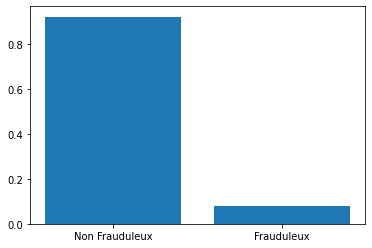

In [ ]:
#Repartition des transactions frauduleuses dans la base principale
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

bars = ax.bar(x=np.arange(tab.size),height=tab['TransactionID'],tick_label=['Non Frauduleux', 'Frauduleux'])
del tab

L'analyse du graphe ci dessus indiquant la repartition des transactions de notre base de données suivant qu'elles sont frauduleuse ou non indique que, près de $10\%$  des transactions sont frauduleuses. Etant donnée que les transactieons non frauduleuses sont sureprésentées. Nous procéderons à un réequilibrage de la base avant l'étape de modélisation. 

* **TransactionAmt**

count    144233.000000
mean         83.554533
std          99.850258
min           0.251000
25%          25.453000
50%          50.000000
75%         100.000000
max        1800.000000
Name: TransactionAmt, dtype: float64


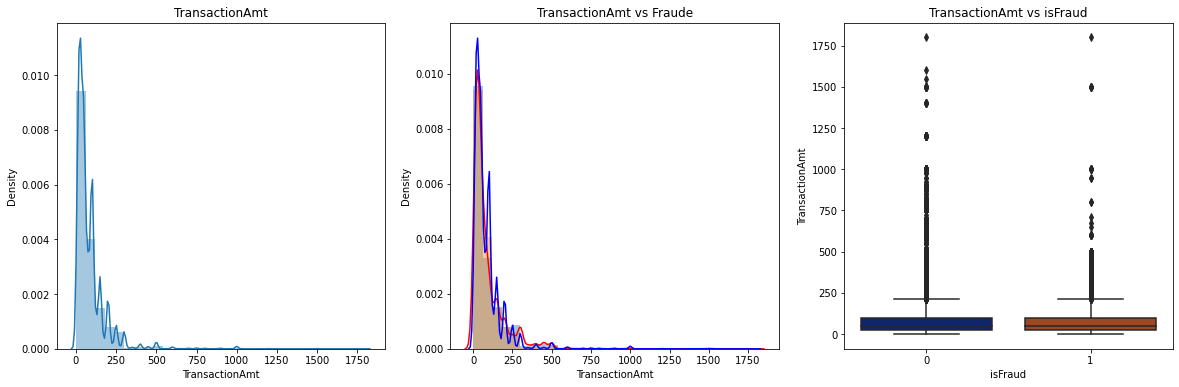

In [ ]:
#Apercu générale sur la variable
print(train['TransactionAmt'].describe())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,3,1)
sns.distplot(train.TransactionAmt,bins=30,label='TransactionAmt')
plt.title('TransactionAmt')

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,3,2)
sns.distplot(train[train['isFraud']==1].TransactionAmt,bins=30,kde_kws={"color": "r"},label='TransactionAmt_Fraude')
sns.distplot(train[train['isFraud']==0].TransactionAmt,bins=30,kde_kws={"color": "b"},label='TransactionAmt_Nofraude')
plt.title('TransactionAmt vs Fraude')

plt.subplot(1,3,3)
sns.boxplot(x='isFraud', y='TransactionAmt',data=train,palette='dark')
plt.title('TransactionAmt vs isFraud')
plt.show()


Ci dessuus nous avons un appercu générale sur la distribution des montants des transaction effectuées dans notre base, ainsi qu'une repartition suivant le caractère frauduleux de la transaction. On peut faire les constats suivant: 

* En moyenne le montant des opérations effectuées par la carte bancaire est de $84$ UC (UC=unité de compte). Toutefois le monde d'une opération sur deux est de moins de $50$ UC. 
* La dispersion du montant des transactions est prèsque identique dans les deux groupes: le goupe des transactions frauduleuses et celui des non frauduleuses.  

* **Les features Cardi**

count    144233.000000
mean       9879.012528
std        5047.643179
min        1000.000000
25%        5713.000000
50%        9633.000000
75%       15063.000000
max       18396.000000
Name: card1, dtype: float64


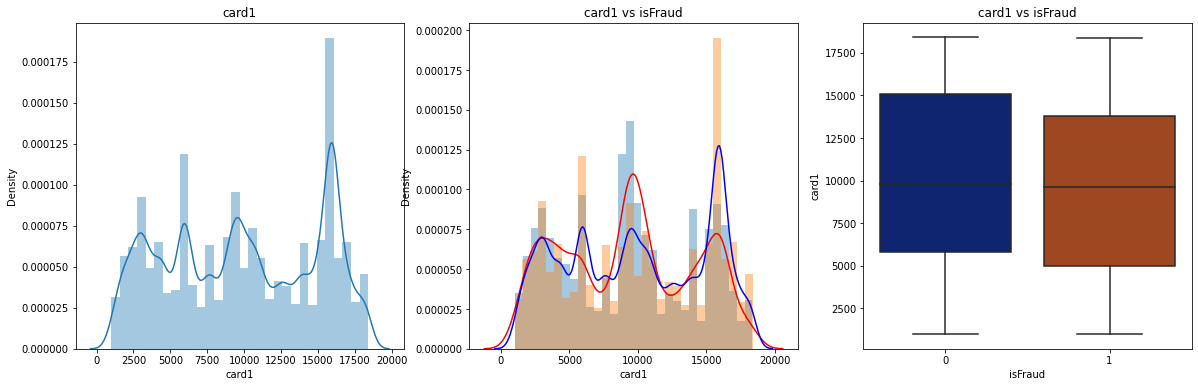

count    143331.000000
mean        391.325526
std         160.327848
min         100.000000
25%         264.000000
50%         408.000000
75%         545.000000
max         600.000000
Name: card2, dtype: float64


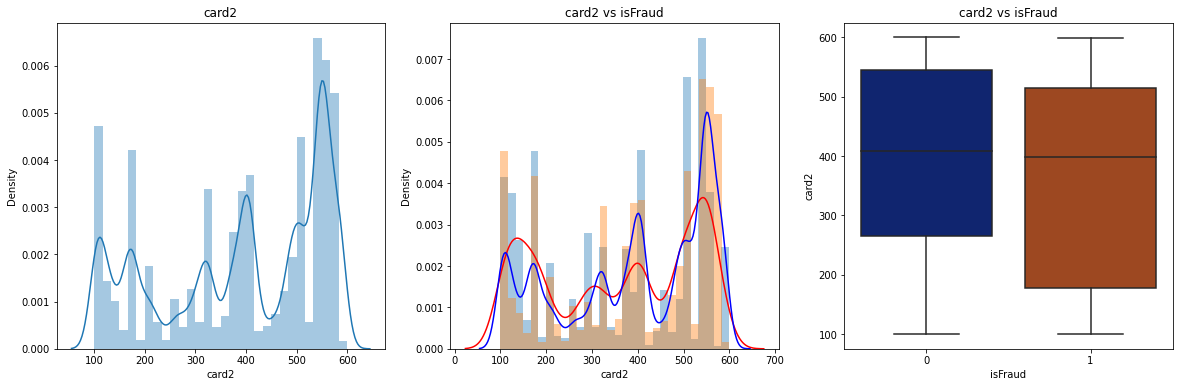

count    144061.000000
mean        161.695504
std          19.410116
min         100.000000
25%         150.000000
50%         150.000000
75%         185.000000
max         231.000000
Name: card3, dtype: float64


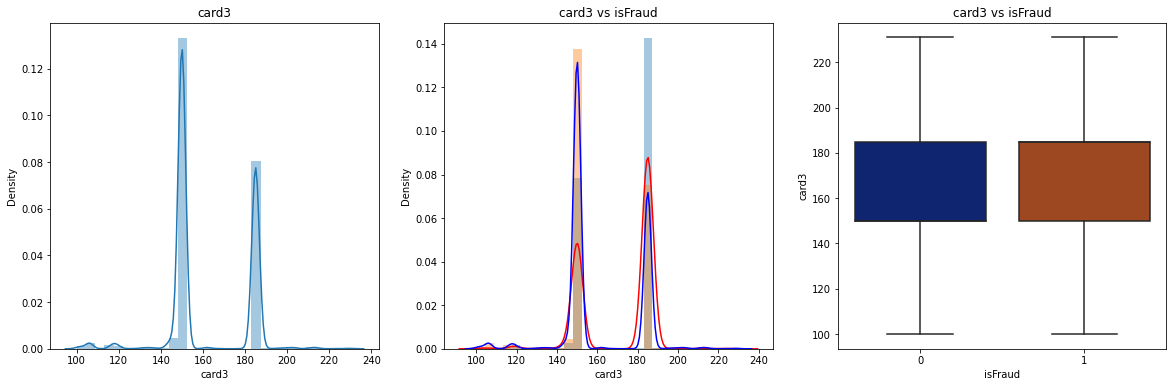

count    143277.000000
mean        191.166293
std          44.774337
min         100.000000
25%         138.000000
50%         224.000000
75%         226.000000
max         237.000000
Name: card5, dtype: float64


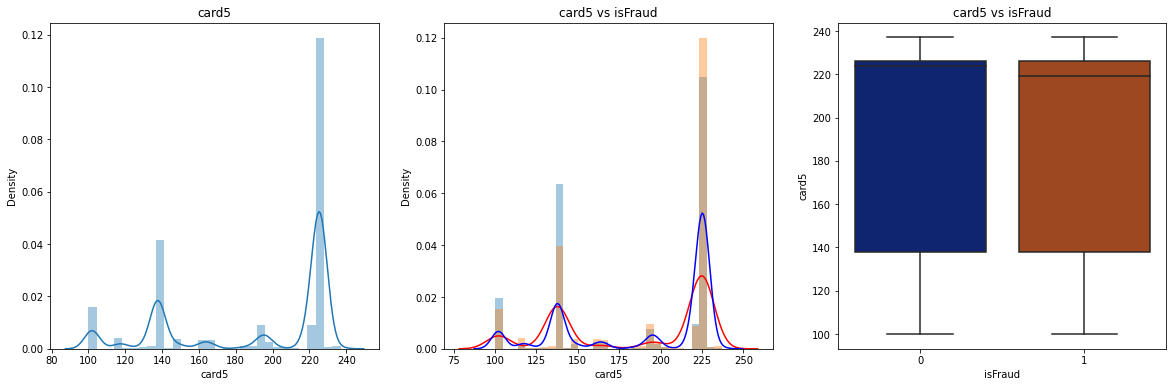

In [ ]:
for i in (1,2,3,5):
  varc='card'+str(i)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()



Les resultats ci dessus prensentent une distribution des variables Cardi. Au vu de ces derniers, on peut tirer les conclusions suivantes: 
* Les cartes banquaires dont Card1 tourne autour de $10000$ ont une très grande propention d'etre victime de fraude et ceci contrairement au cartes ayant une valeur de Card1 autour de $15700$.
* Pour ce qui est de la variable Card2, on remarque que plus la valeur de card2 est faible, plus la carte bancaire est succeptible d'etre victime de fraude. 
* Quant à la variable Card3, les cartes banquaires dont Card3 tourne autour de $190$ ont une très grande propention d'etre victime de fraude et ceci contrairement au cartes ayant une valeur de Card1 autour de $150$.



* **Les features Ci**

count    144233.000000
mean         27.793681
std         249.745336
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        4685.000000
Name: C1, dtype: float64


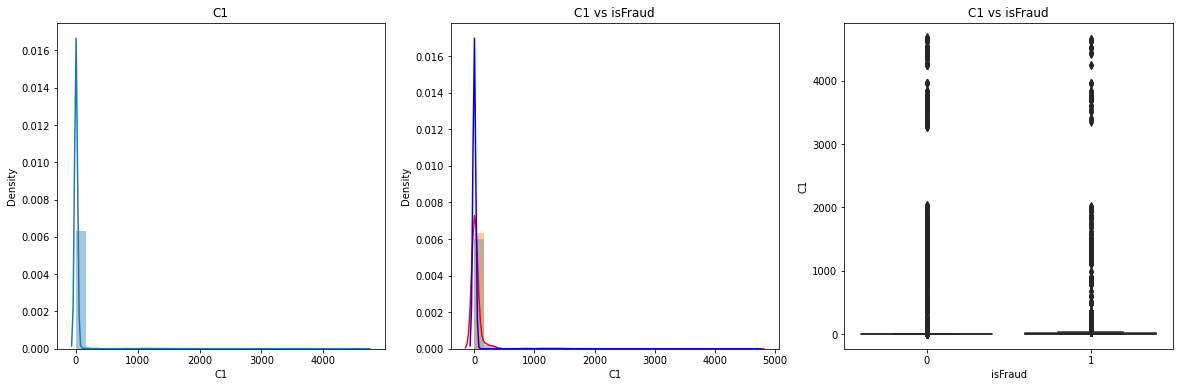

count    144233.000000
mean         34.344533
std         291.306999
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        5691.000000
Name: C2, dtype: float64


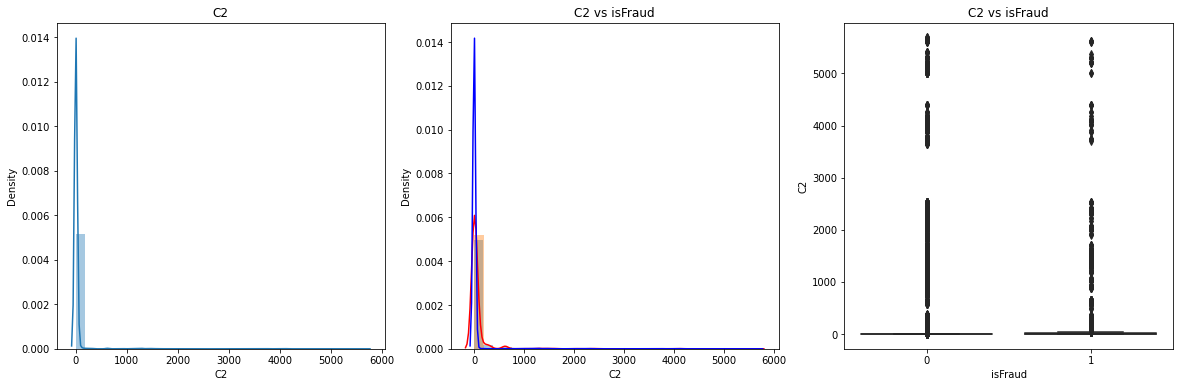

count    144233.000000
mean          0.023032
std           0.303819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          26.000000
Name: C3, dtype: float64


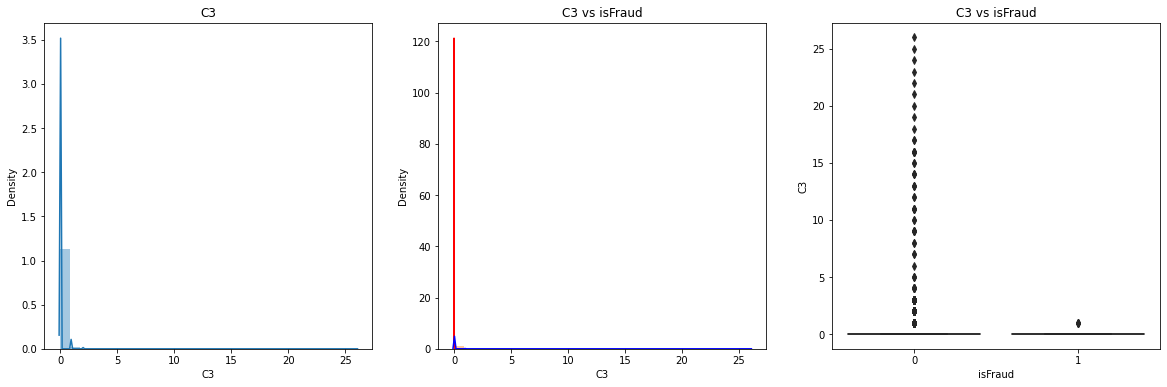

count    144233.000000
mean         15.603558
std         131.944756
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2253.000000
Name: C4, dtype: float64


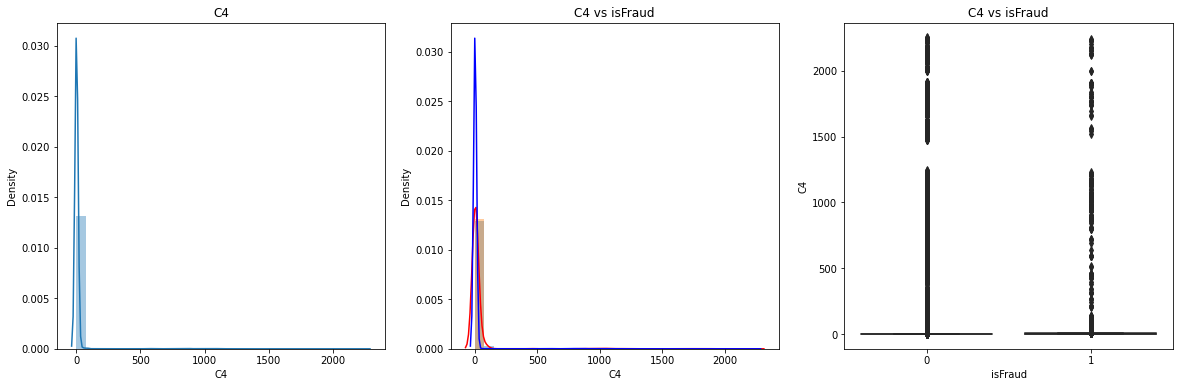

count    144233.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: C5, dtype: float64


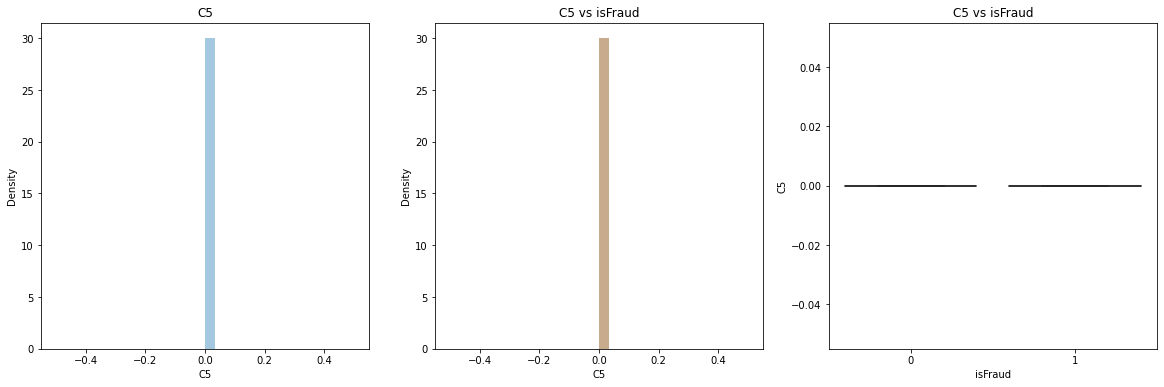

count    144233.000000
mean         15.583036
std         132.514335
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2253.000000
Name: C6, dtype: float64


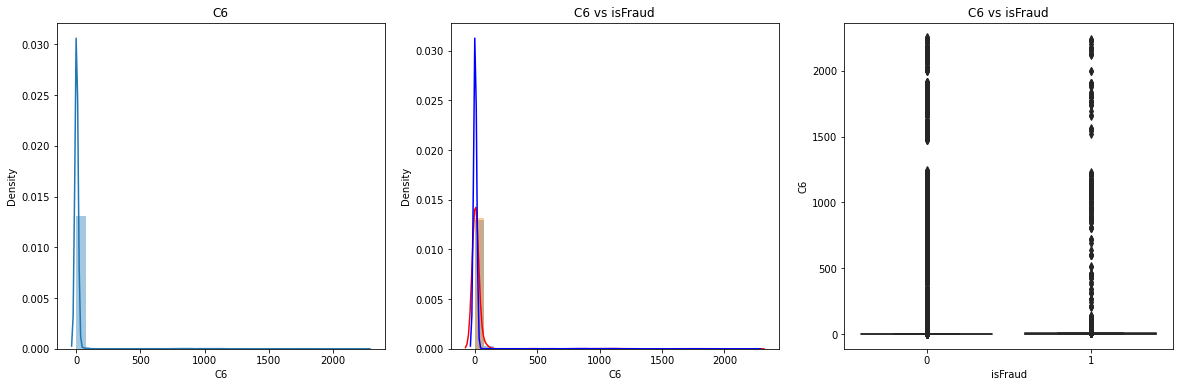

count    144233.000000
mean         10.512830
std         117.037122
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        2255.000000
Name: C7, dtype: float64


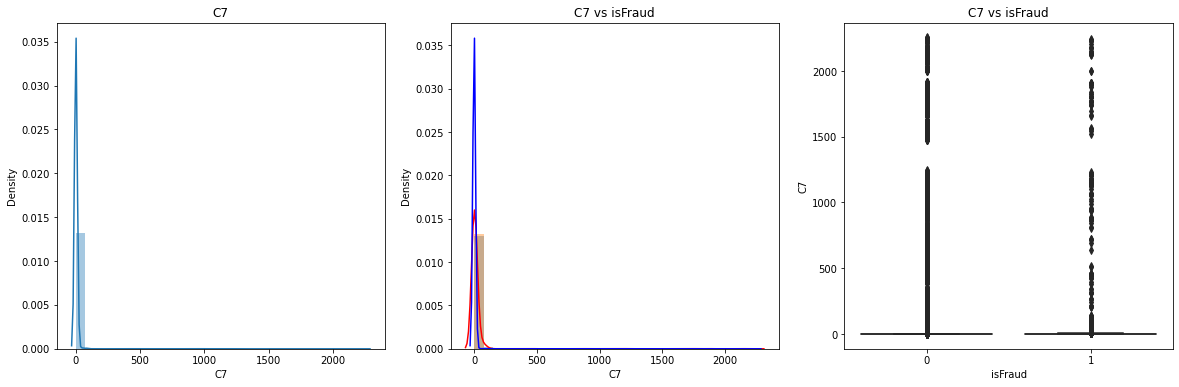

count    144233.000000
mean         19.395173
std         181.039192
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        3331.000000
Name: C8, dtype: float64


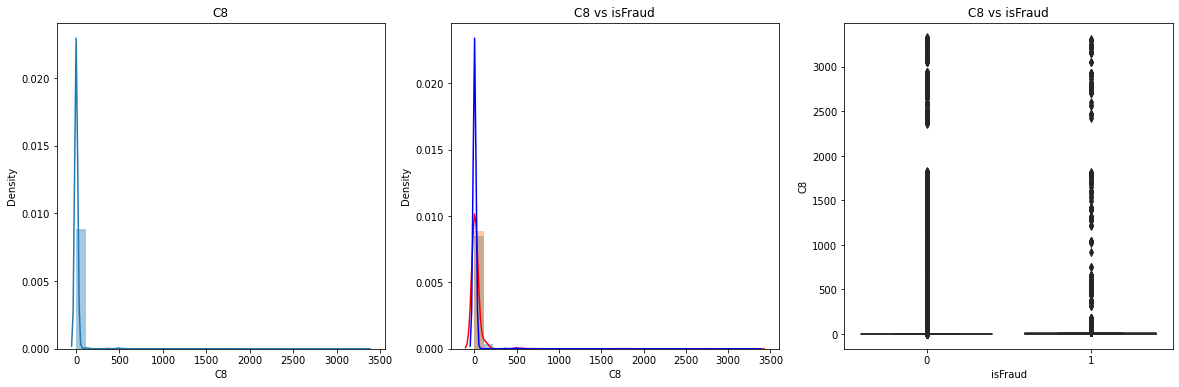

count    144233.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: C9, dtype: float64


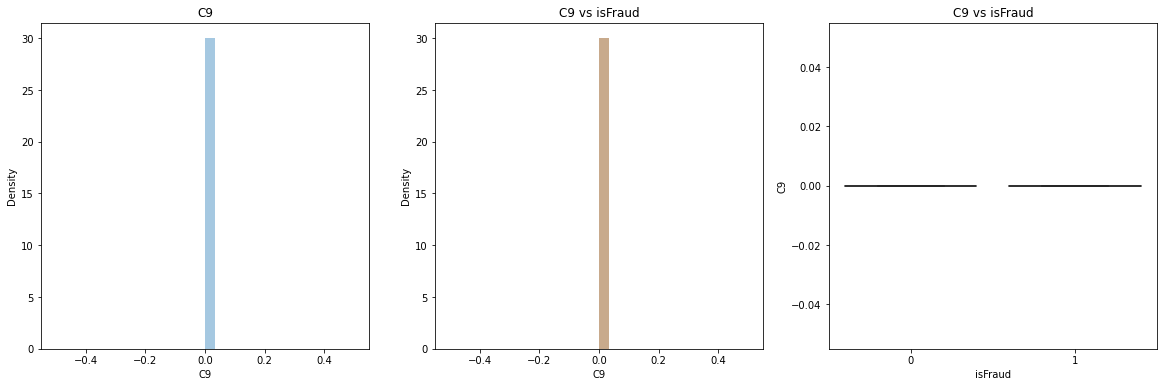

count    144233.000000
mean         19.787483
std         181.760988
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3257.000000
Name: C10, dtype: float64


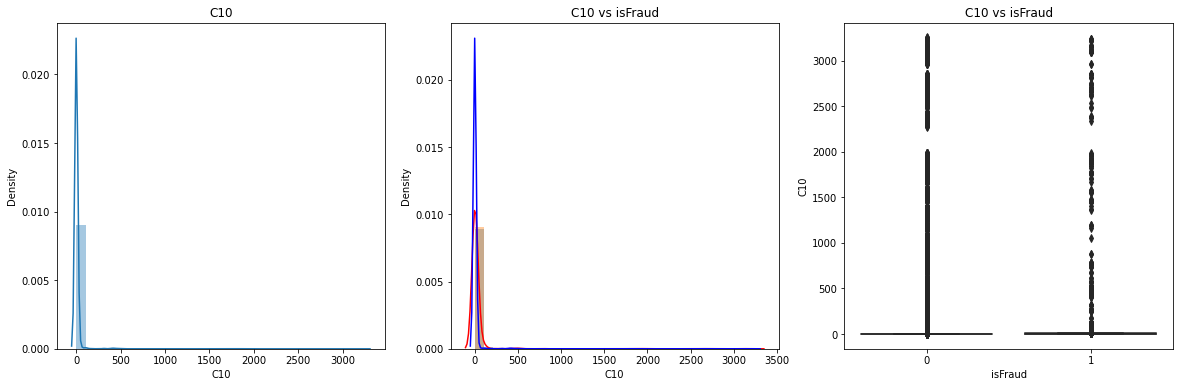

count    144233.000000
mean         20.359425
std         176.778700
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3188.000000
Name: C11, dtype: float64


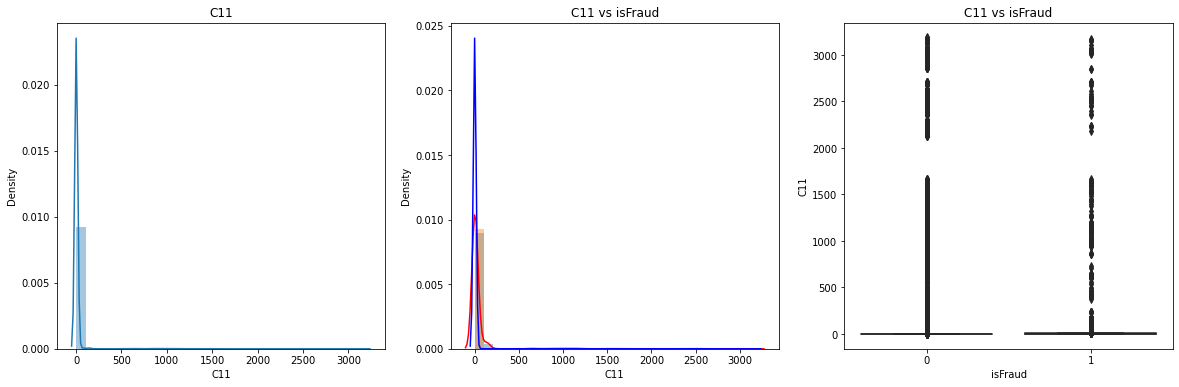

count    144233.000000
mean         14.811687
std         164.194903
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        3188.000000
Name: C12, dtype: float64


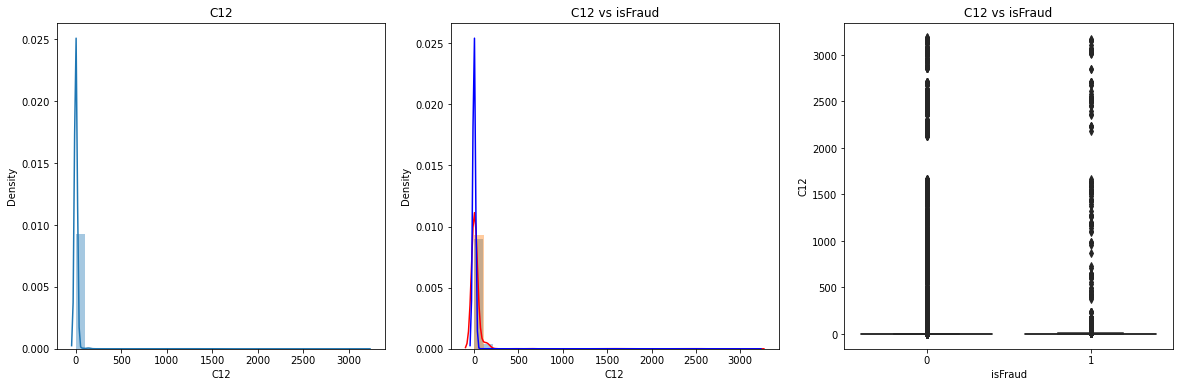

count    144233.000000
mean         20.517850
std         165.660021
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2918.000000
Name: C13, dtype: float64


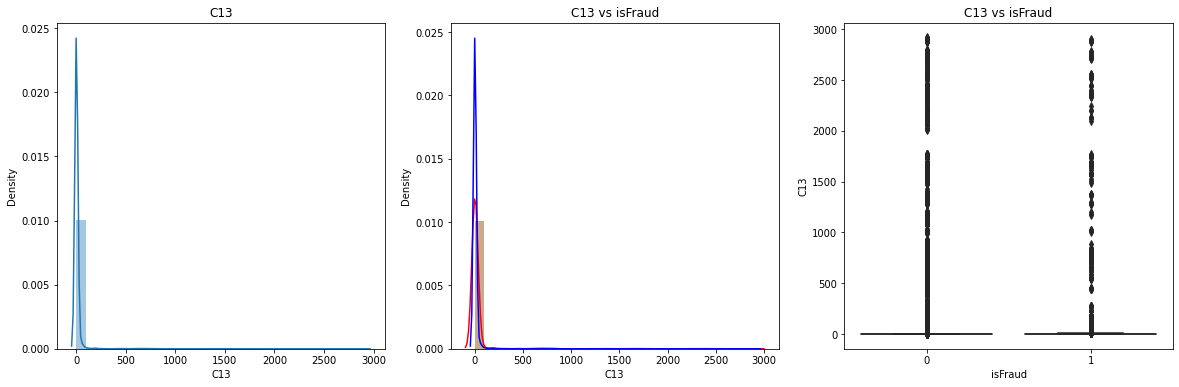

count    144233.000000
mean         10.499685
std          87.186134
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1429.000000
Name: C14, dtype: float64


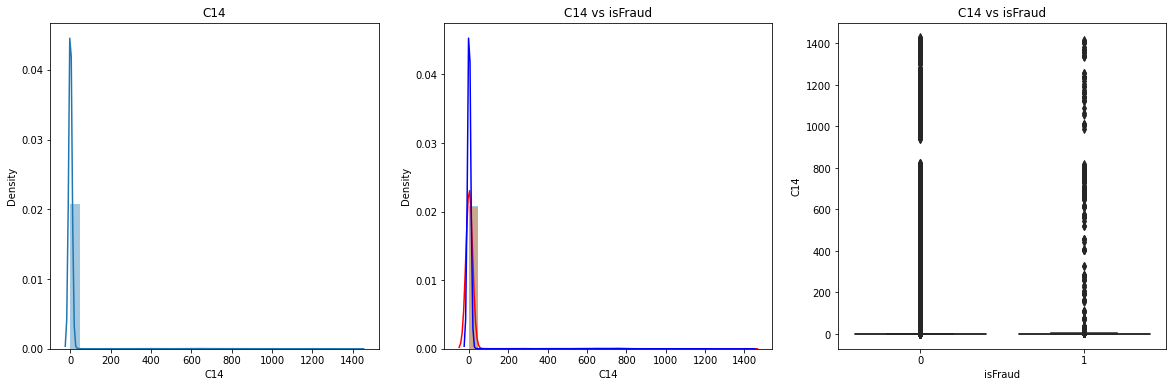

In [ ]:
for i in range(14):
  varc='C'+str(i+1)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


L'analyse des resultats ci-dessus concernant les variables "Ci" de notre base nous montre de facon générale que ces variables presententes  des forts taux de valeurs aberrantes. Avant la modélisation, nous procéderons au préalable à un traitement de ces valeurs abérrantes. 

* **Feature D1**

count    144015.000000
mean         29.313724
std          95.198009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         640.000000
Name: D1, dtype: float64


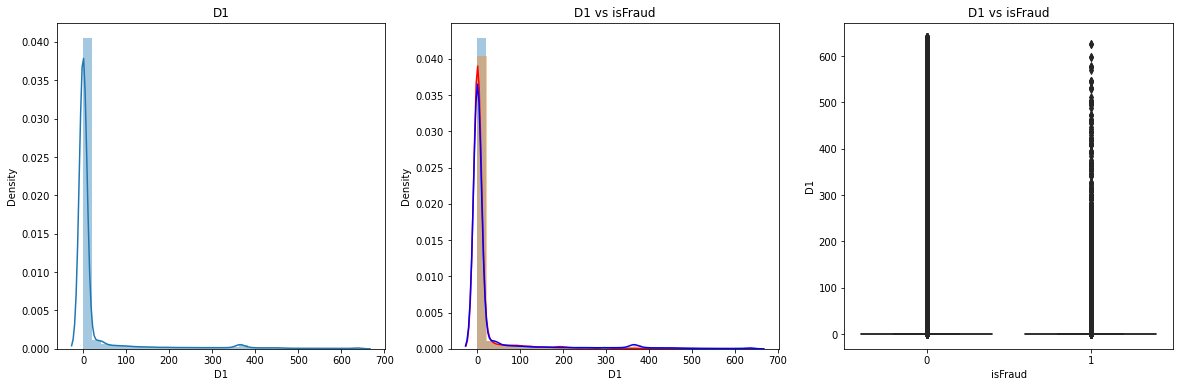

In [ ]:
for i in range(1):
  varc='D'+str(i+1)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Features Vi**

count    144169.000000
mean          3.562839
std          42.394744
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         880.000000
Name: V95, dtype: float64


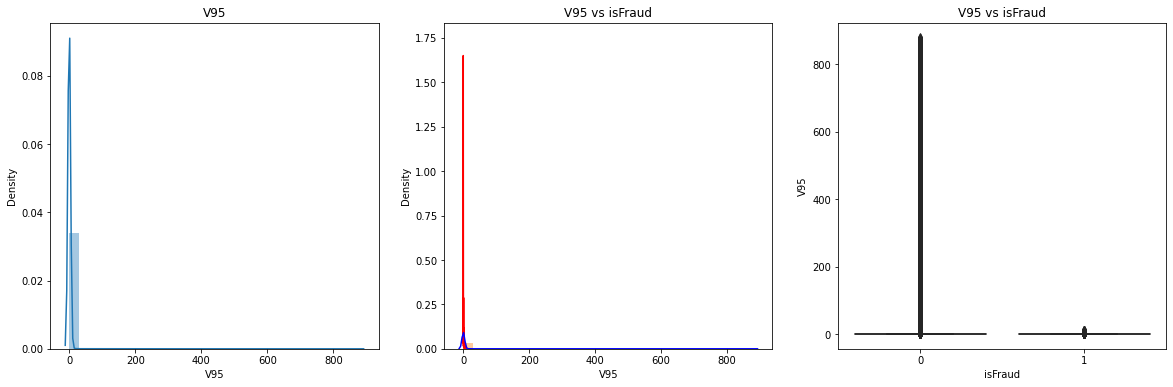

count    144169.000000
mean          7.429760
std          80.780593
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1410.000000
Name: V96, dtype: float64


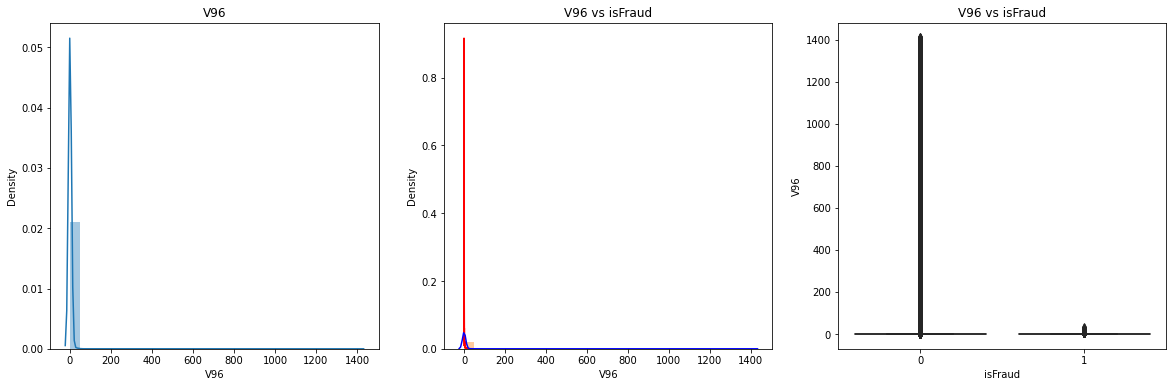

count    144169.000000
mean          5.235633
std          55.771274
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         976.000000
Name: V97, dtype: float64


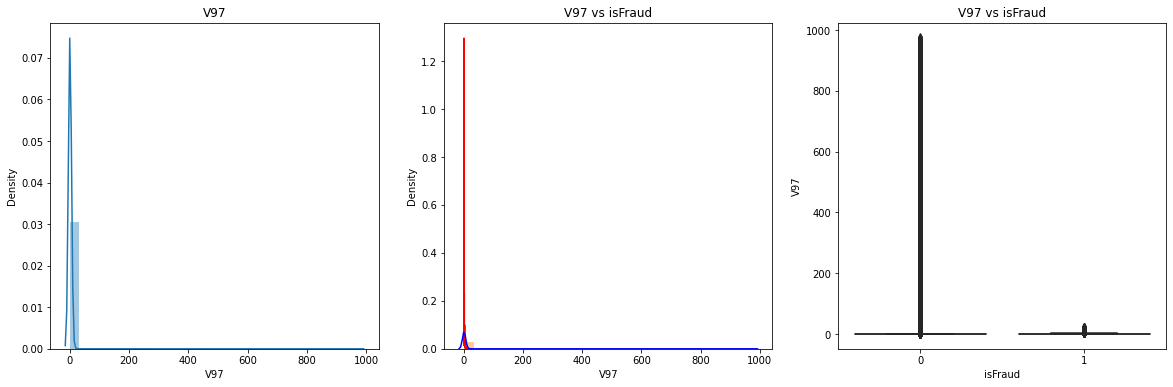

count    144169.000000
mean          0.032219
std           0.226304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V98, dtype: float64


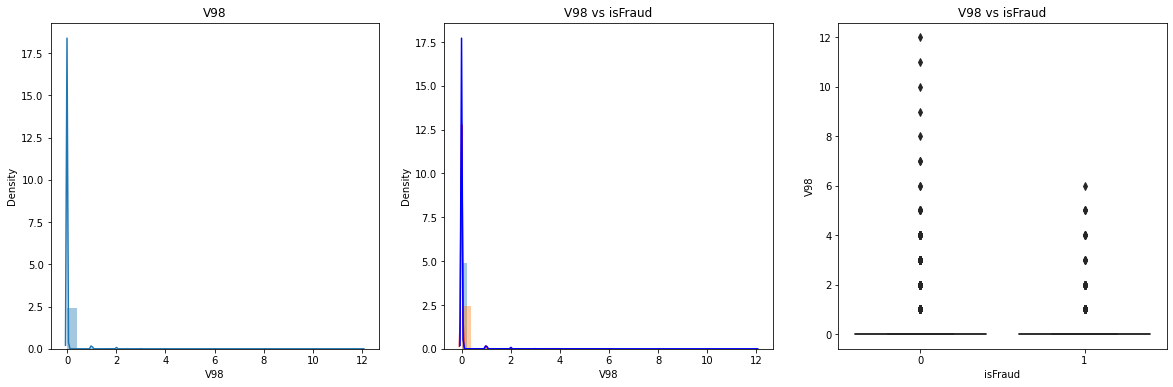

count    144169.000000
mean          0.450263
std           2.940506
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          43.000000
Name: V99, dtype: float64


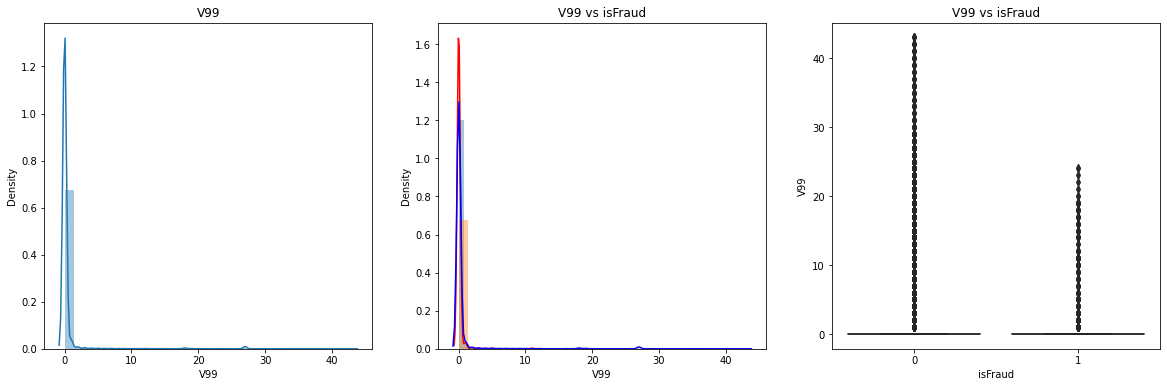

count    144169.000000
mean          0.159355
std           1.021986
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.000000
Name: V100, dtype: float64


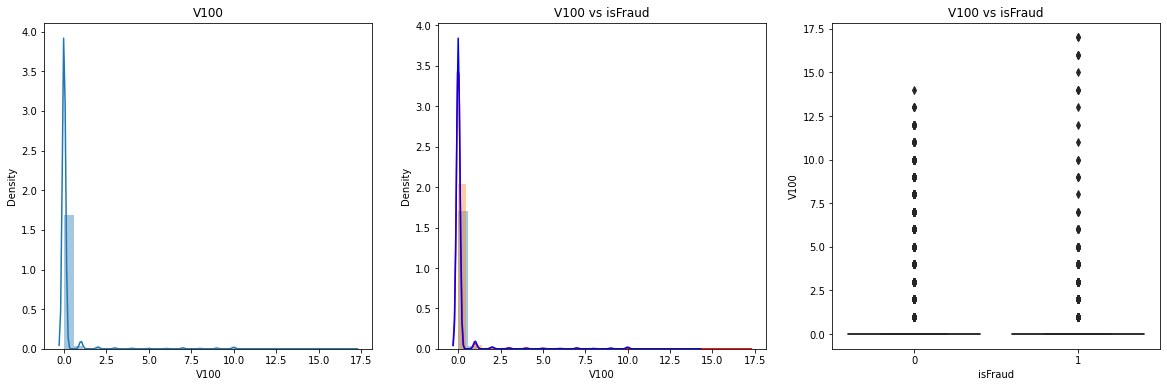

count    144169.000000
mean          3.338471
std          41.494225
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         869.000000
Name: V101, dtype: float64


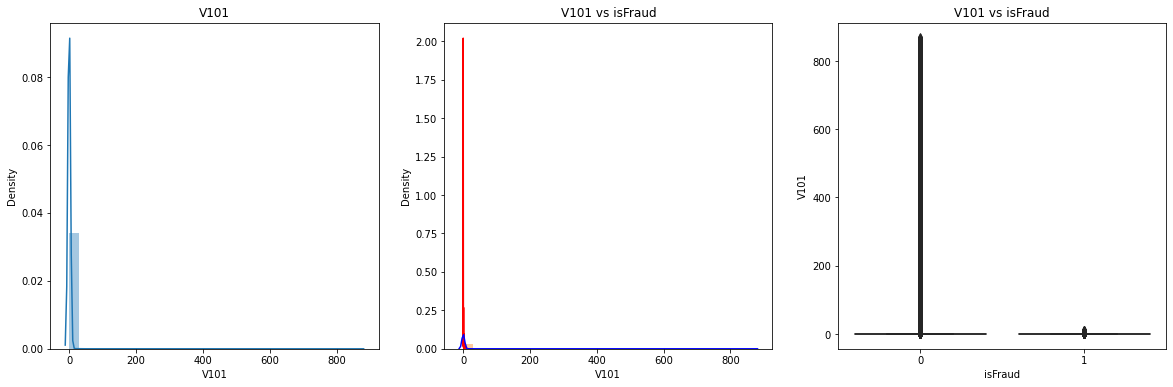

count    144169.000000
mean          6.237048
std          72.287288
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1285.000000
Name: V102, dtype: float64


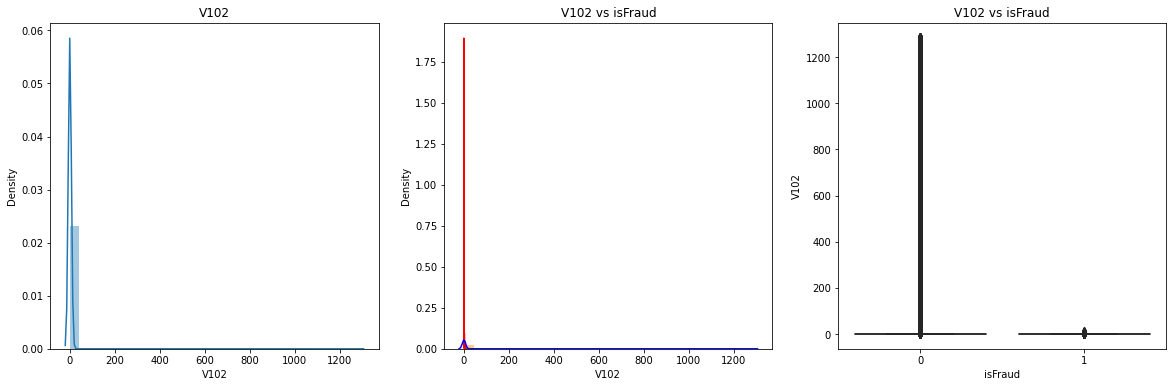

count    144169.000000
mean          4.636031
std          51.746309
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         928.000000
Name: V103, dtype: float64


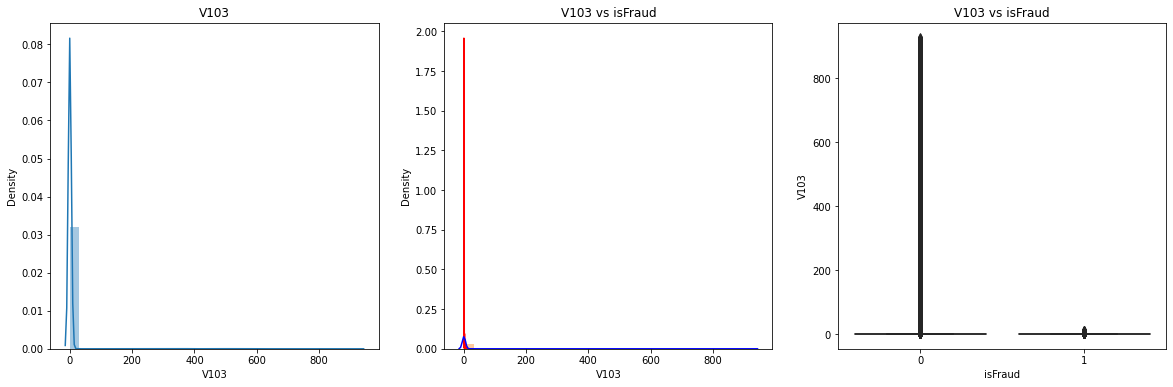

count    144169.000000
mean          0.187162
std           1.191219
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V104, dtype: float64


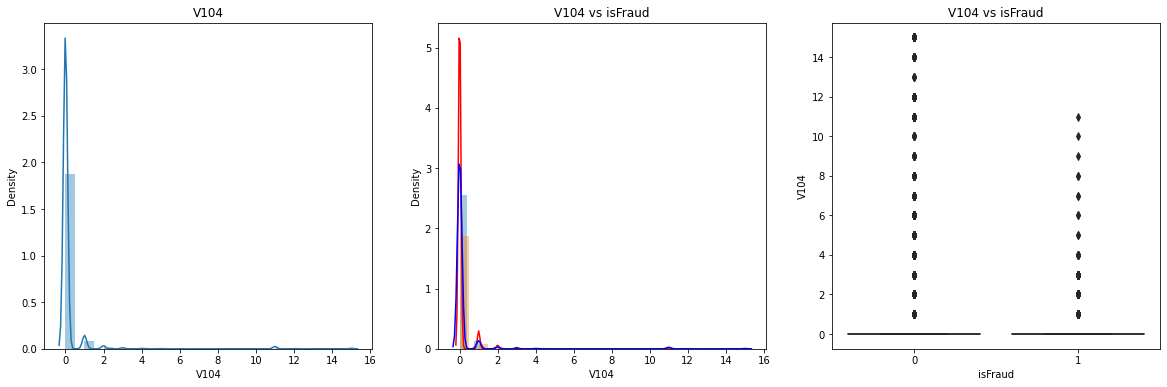

count    144169.000000
mean          0.735935
std           6.650123
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          99.000000
Name: V105, dtype: float64


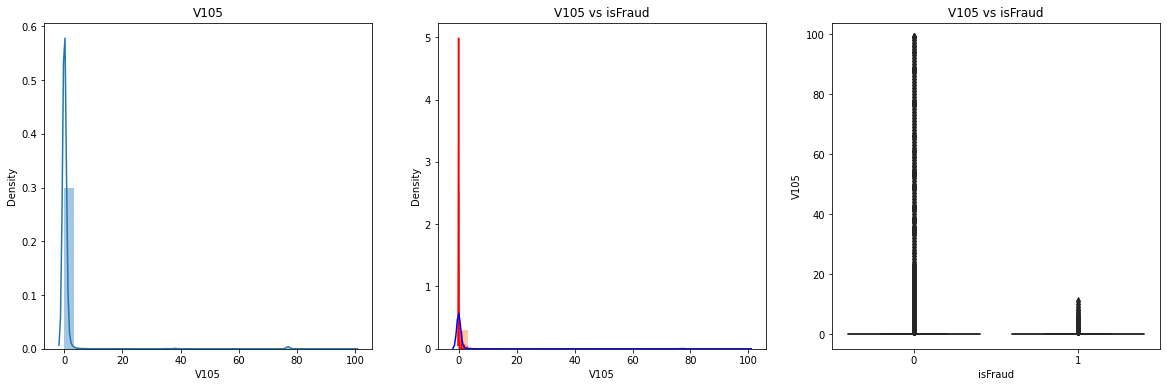

count    144169.000000
mean          0.434594
std           3.586018
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          55.000000
Name: V106, dtype: float64


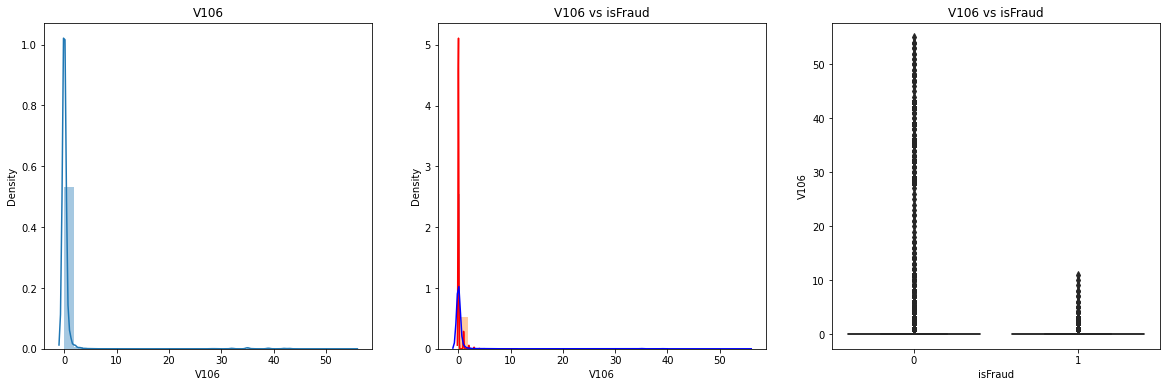

count    144169.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: V107, dtype: float64


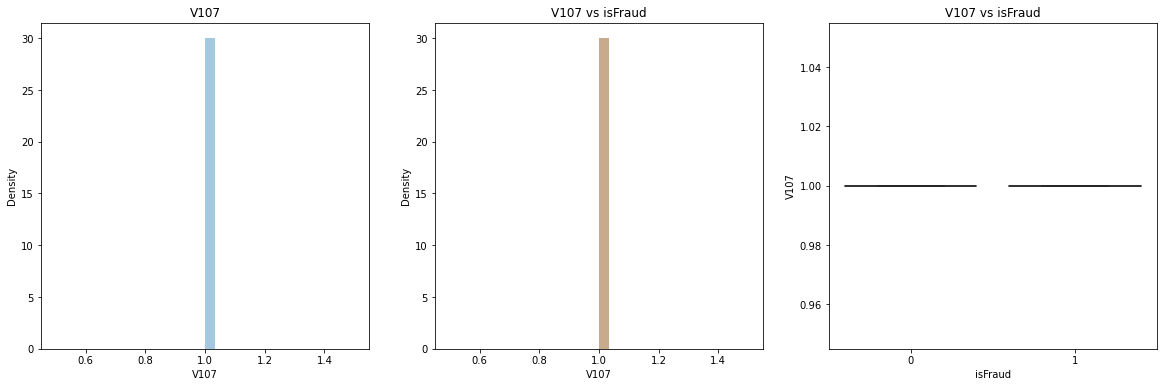

count    144169.000000
mean          1.008213
std           0.112551
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V108, dtype: float64


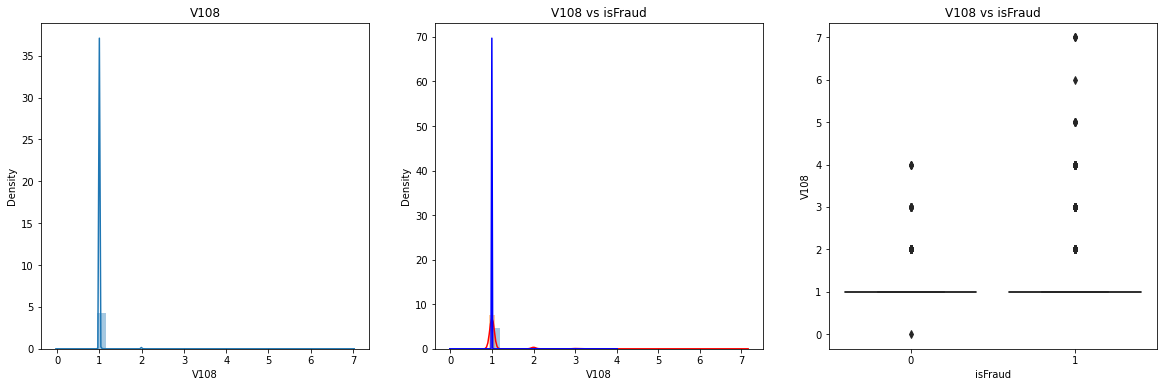

count    144169.000000
mean          1.008663
std           0.114503
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V109, dtype: float64


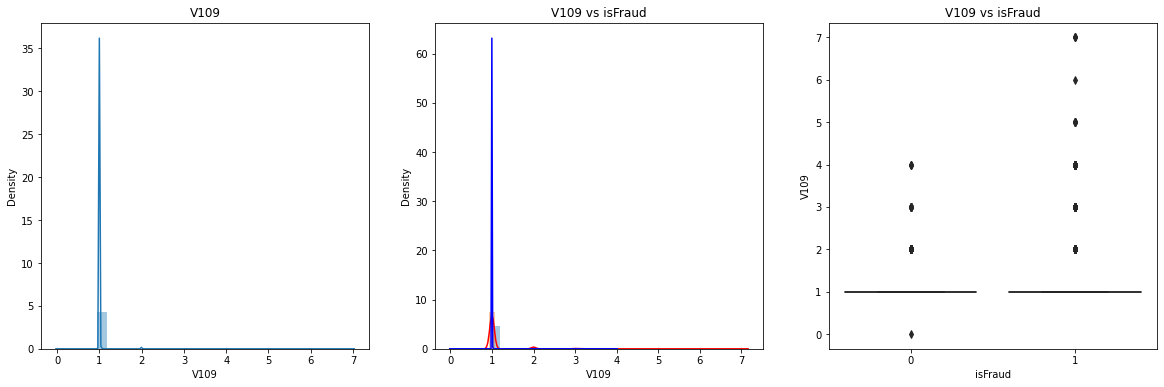

count    144169.000000
mean          1.008379
std           0.113276
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V110, dtype: float64


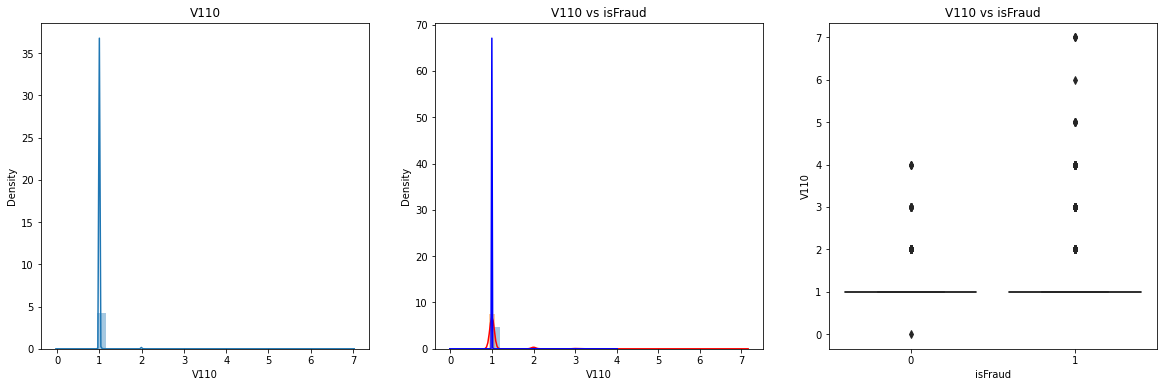

count    144169.000000
mean          1.009336
std           0.125742
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V111, dtype: float64


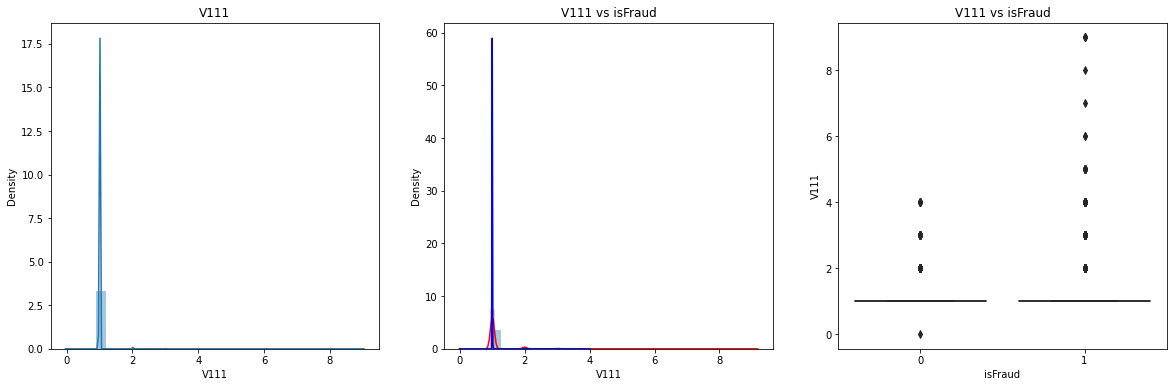

count    144169.000000
mean          1.009621
std           0.126901
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V112, dtype: float64


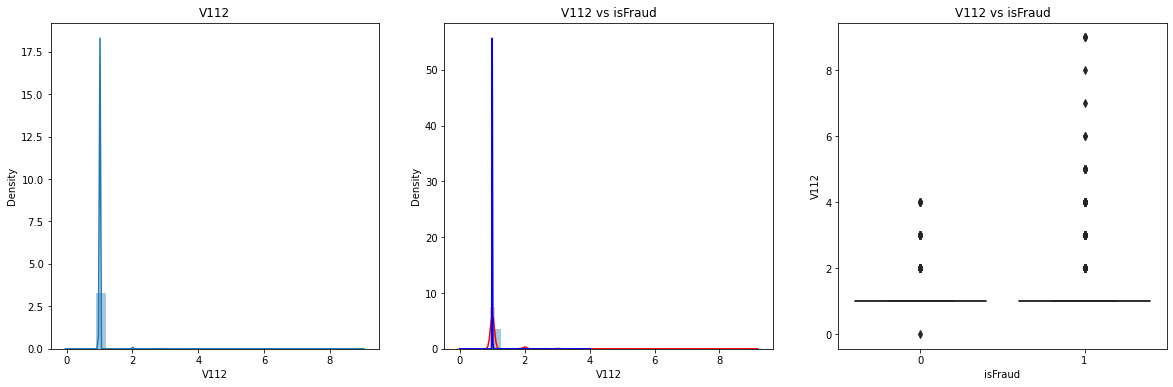

count    144169.000000
mean          1.009510
std           0.126471
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V113, dtype: float64


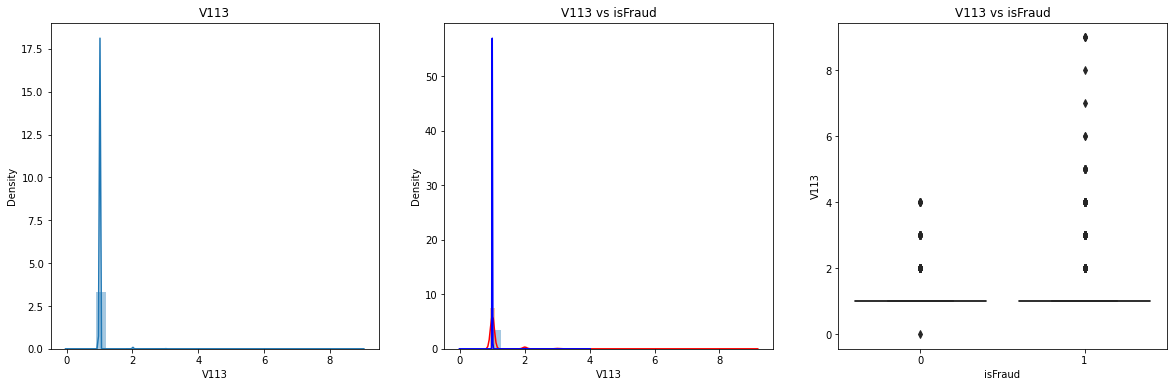

count    144169.000000
mean          1.015100
std           0.148801
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V114, dtype: float64


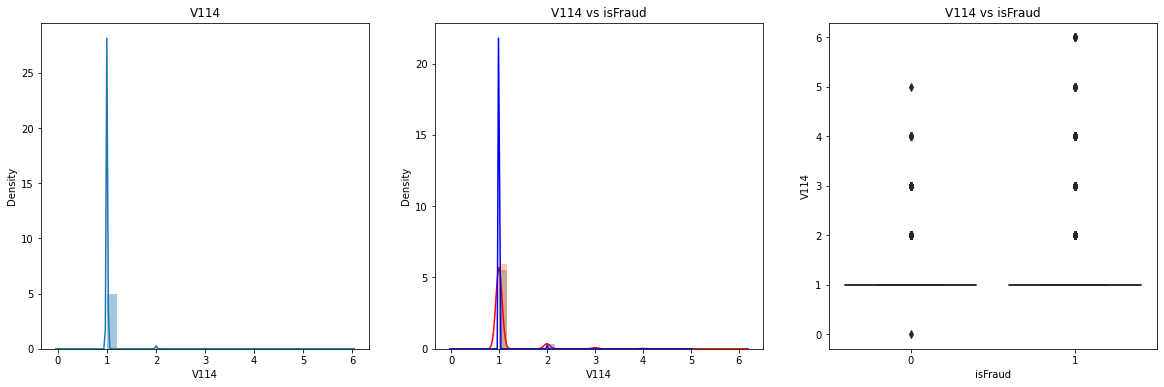

In [ ]:
for i in range(20):
  varc='V'+str(i+95)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


L'analyse des resultats ci-dessus concernant les variables "Vi" de notre base nous montre de facon générale que ces variables presententes  des forts taux de valeurs aberrantes. Avant la modélisation, nous procéderons au préalable à un traitement de ces valeurs abérrantes. 

* **Card4**

visa                89299
mastercard          44186
american express     8298
discover             2266
Name: card4, dtype: int64


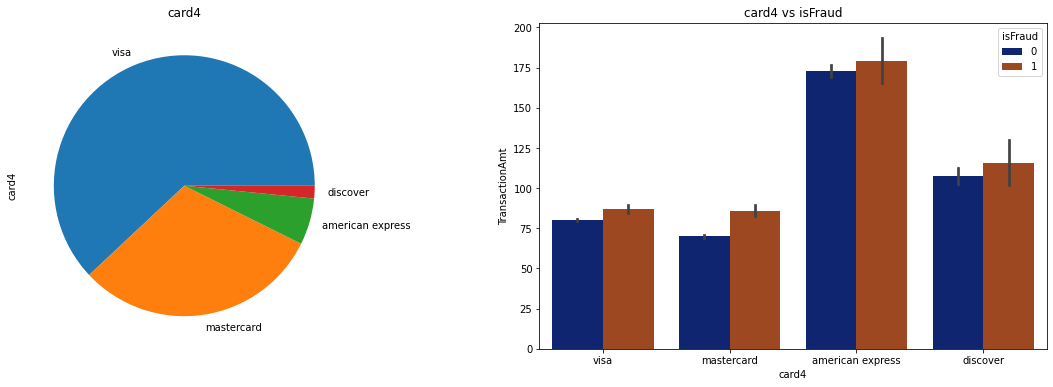

In [ ]:
varc='card4'
#Apercu générale sur la variable
print(train[varc].value_counts())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,2,1)
train[varc].value_counts(normalize=True).plot(kind='pie')
plt.title(varc)

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,2,2)
sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
plt.title(varc+' vs isFraud')
plt.show()



Les resultats ci-dessus mon présente la repartition des trasaction en fonction du type de carte bancaire. On contate que: 
* Premièrement la carte bancaire la plus utilisée est "Visa".
* En moyenne le montant des transactions frauduleuse est légèrement plus elevé pour tous les types de cartes. 


* **ProbuctCD**

C    62192
R    37548
H    32908
S    11585
Name: ProductCD, dtype: int64


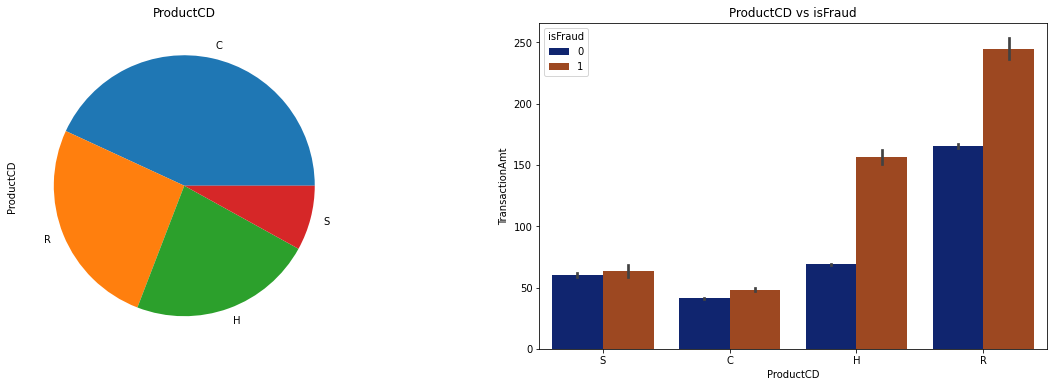

In [ ]:
varc='ProductCD'
#Apercu générale sur la variable
print(train[varc].value_counts())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,2,1)
train[varc].value_counts(normalize=True).plot(kind='pie')
plt.title(varc)

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,2,2)
sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
plt.title(varc+' vs isFraud')
plt.show()

Les resultats ci-dessus mon présente la repartition des trasaction en fonction du type de produit. On contate que: 
* Premièrement les produit "C" et "R" sont les plus representés.
* En moyenne le montant des transactions frauduleuse est  plus elevé que le montant moyen des transactions non frauduleuses pourles produits de type  "H" et "R".

* **Features id quantitatif**

NotFound    123025
Found        21208
Name: id_12, dtype: int64


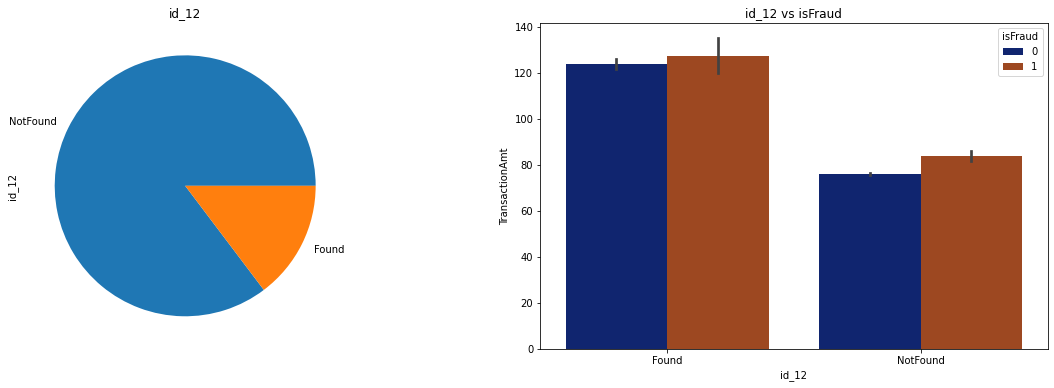

Found      67728
New        61612
Unknown    11645
Name: id_15, dtype: int64


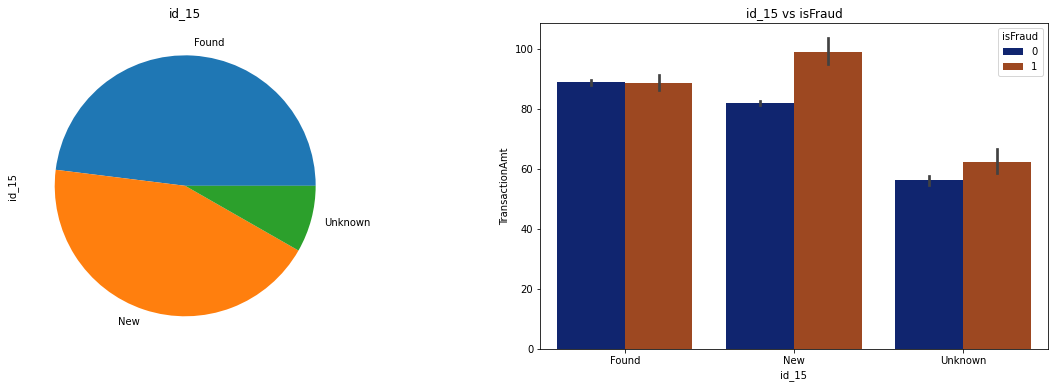

Found       66324
NotFound    63016
Name: id_16, dtype: int64


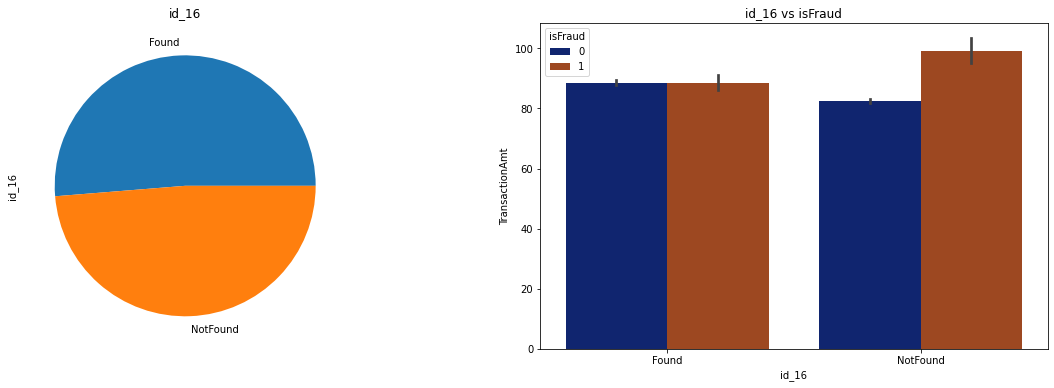

Found    76232
New      64746
Name: id_28, dtype: int64


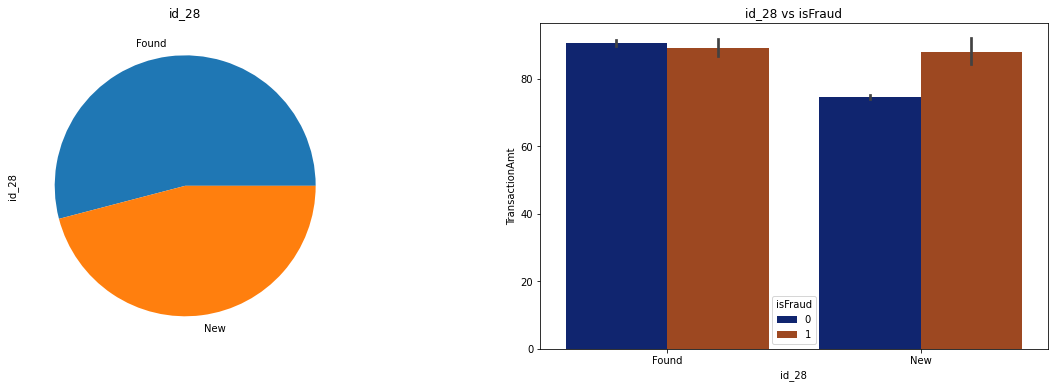

Found       74926
NotFound    66052
Name: id_29, dtype: int64


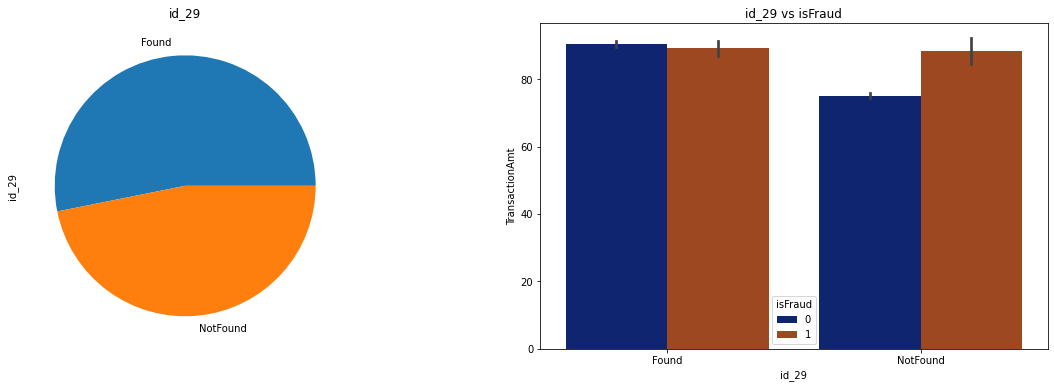

T    77814
F    63171
Name: id_35, dtype: int64


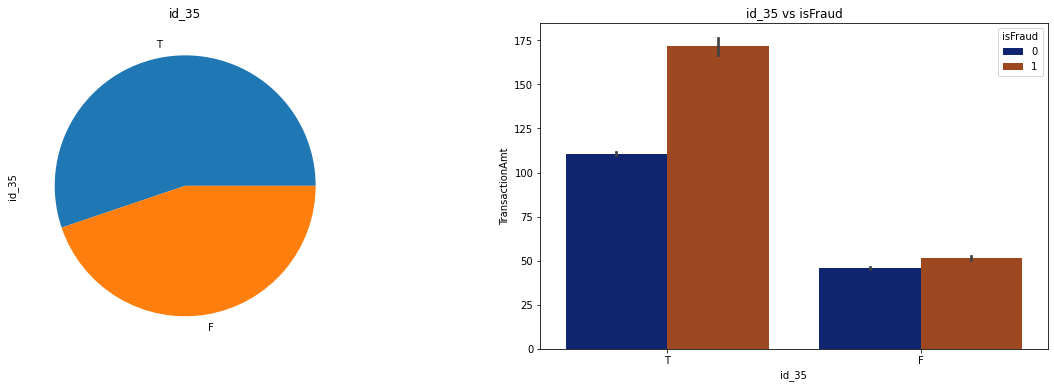

F    134066
T      6919
Name: id_36, dtype: int64


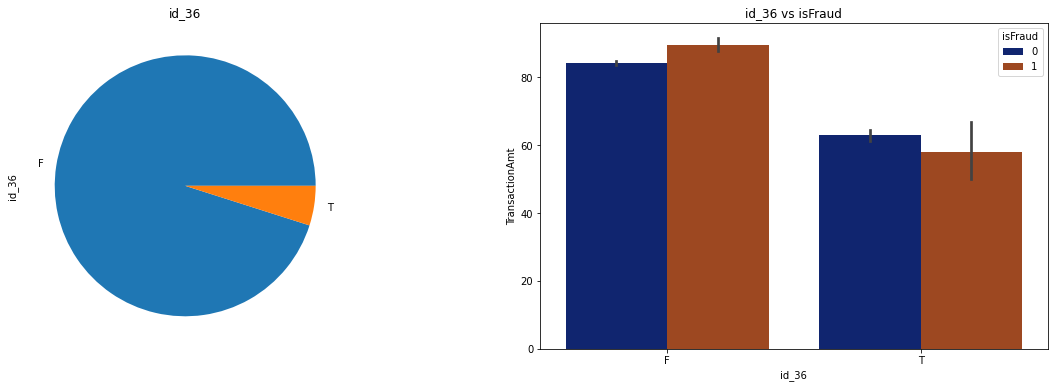

T    110452
F     30533
Name: id_37, dtype: int64


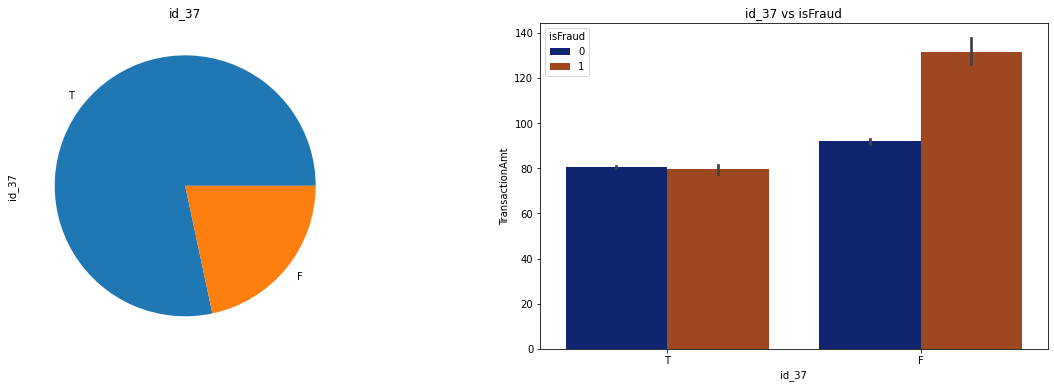

F    73922
T    67063
Name: id_38, dtype: int64


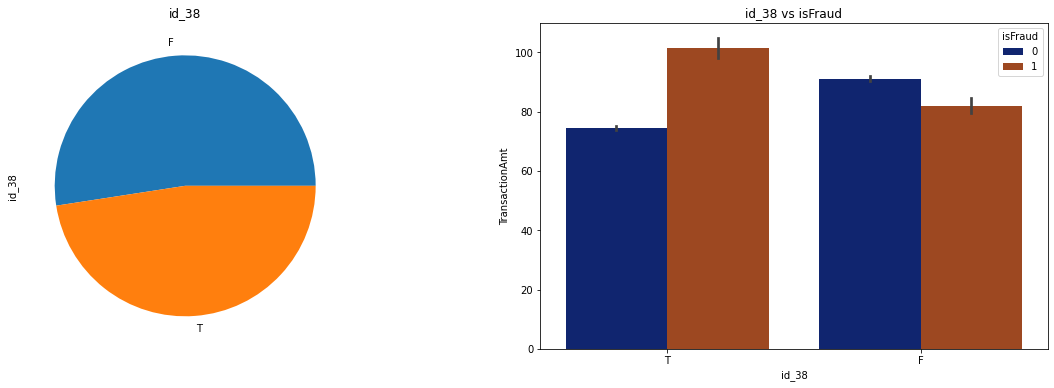

In [ ]:
for i in (12,15,16,28,29,35,36,37,38):
  varc='id_'+str(i)
  #Apercu générale sur la variable
  print(train[varc].value_counts())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,2,1)
  train[varc].value_counts(normalize=True).plot(kind='pie')
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,2,2)
  sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()



***En resumé sur les statistiques descriptives:***
* **On constate qu'il y'a une surrepresentation des transactions non frauduleuses. Pour eviter un surapprentissange de nos modèle, nous procéderons à un réequilibrage de la base avant la partie modélisation.** 

* **On constate de facon générales que les features presentes des valeurs abérrantes. Pour eviter que ces dernières impactes négativements nos modèles, nous allons procéder à une detection de ces valeurs abérrantes puis nous allons les traiter comme des valeurs manquantes de notre base de données.** 

## Pré-traitement des données

En raison de la taille importante de la base de données ainsi que du niveau limité de puissance octroyée par Google Colab. Nous décidons de ne travailler que sur 25% de la base. Etant donné le caractère aléatoire du tirage, cette méthode est satisfaisante car la sous base extraite présente plus ou moins les mêmes caractéristiques que la base initiale.

In [ ]:
train=train.sample(frac=0.25,replace=False, random_state=42)

### **Détection des valeurs manquantes**

In [ ]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.85%


On remarque que la base contient un nombre conséquent de valeurs manquantes. De ce fait, il faudrait optimalement procéder à un traitement de ces valeurs afin de ne pas perdre un nombre trop considérable d'informations. 

Nous commmencons alors par analyser la distribution des données manquantes suivant les variables.

In [ ]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


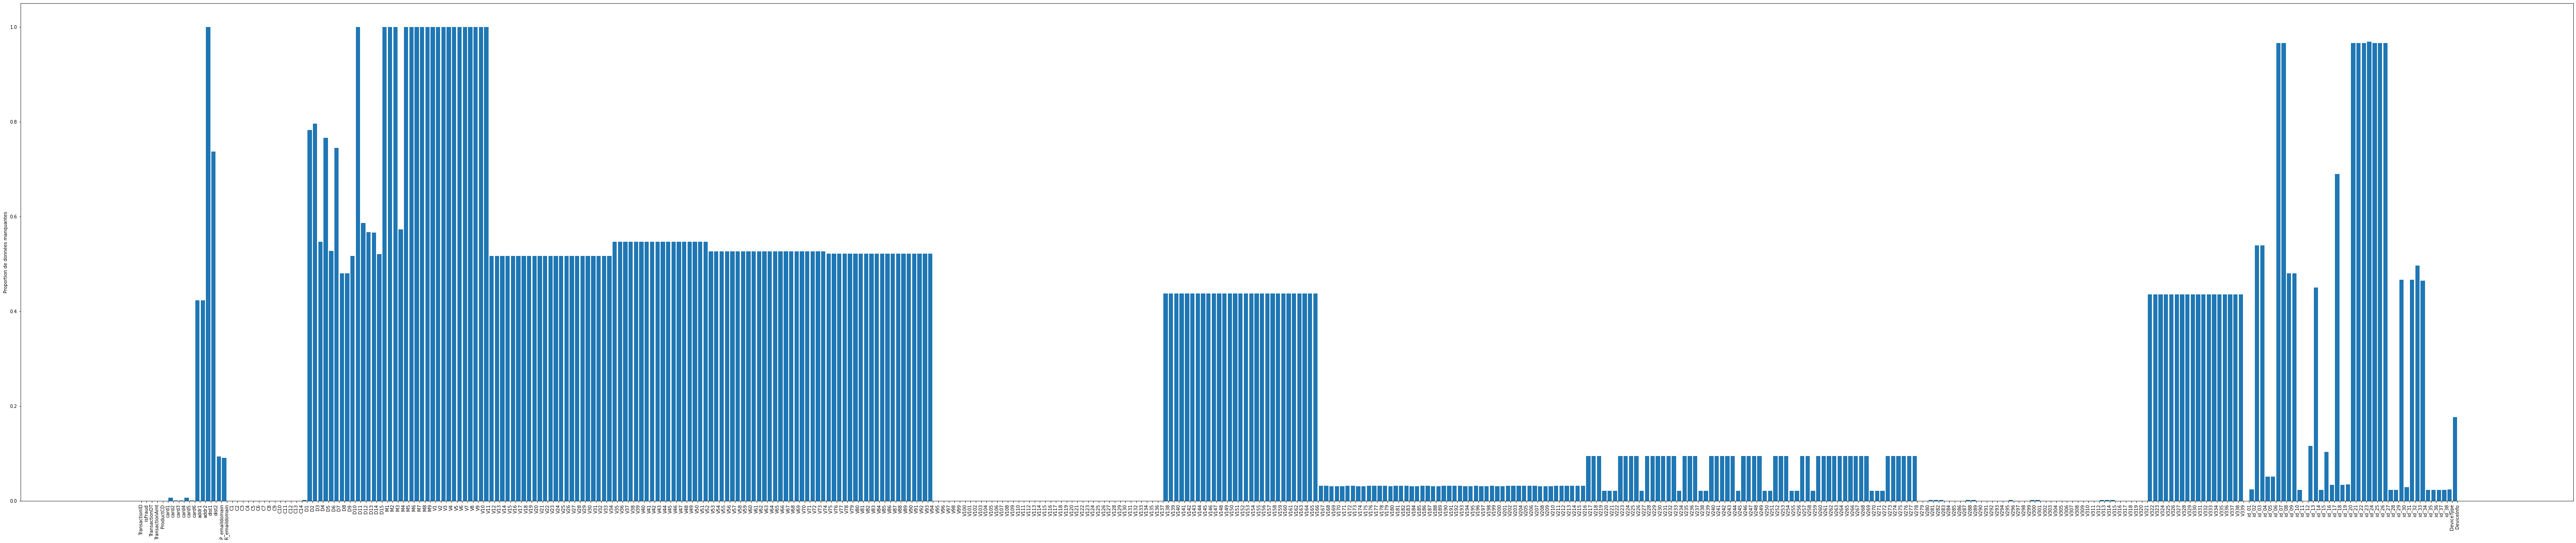

In [ ]:
#Visualisation
missing_view(train)

On note ainsi qu'il existe plusieurs variables avec un nombre trop grands de valeurs manquantes, on pense donc à procéder à leur suppression. Toutefois, une analyse plus fine suivant la variable d'intérêt pourra peut-être révéler des différences entre sous-ensembles.

### **Analyse de la variable d'intérêt**

In [ ]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,33144
1,2914


Text(0.5, 1.0, 'Distribution de la variable isFraud')

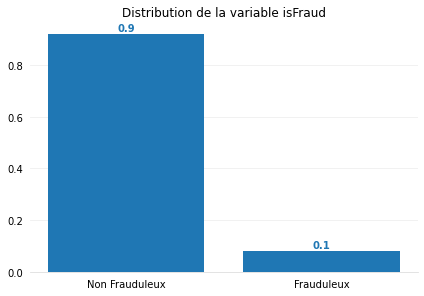

In [ ]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

Le premier constant est le caractère déséquilibré de la base de données. En effet, les données non frauduleuses sont 9 fois plus importantes que les données frauduleuses, on soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [ ]:
#Recalibrage
class0= train[train['isFraud']==0]  
class1= train[train['isFraud']==1]
class0_downsample=class0.sample(n = len(class1), replace=False, random_state=42)
train_calibrate=class0_downsample.append(class1)

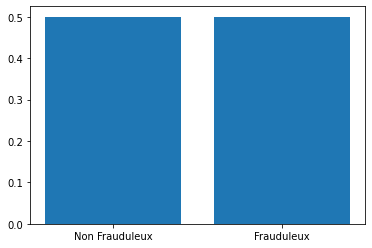

In [ ]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

### **Visualisation des données manquantes dans la base recalibré**

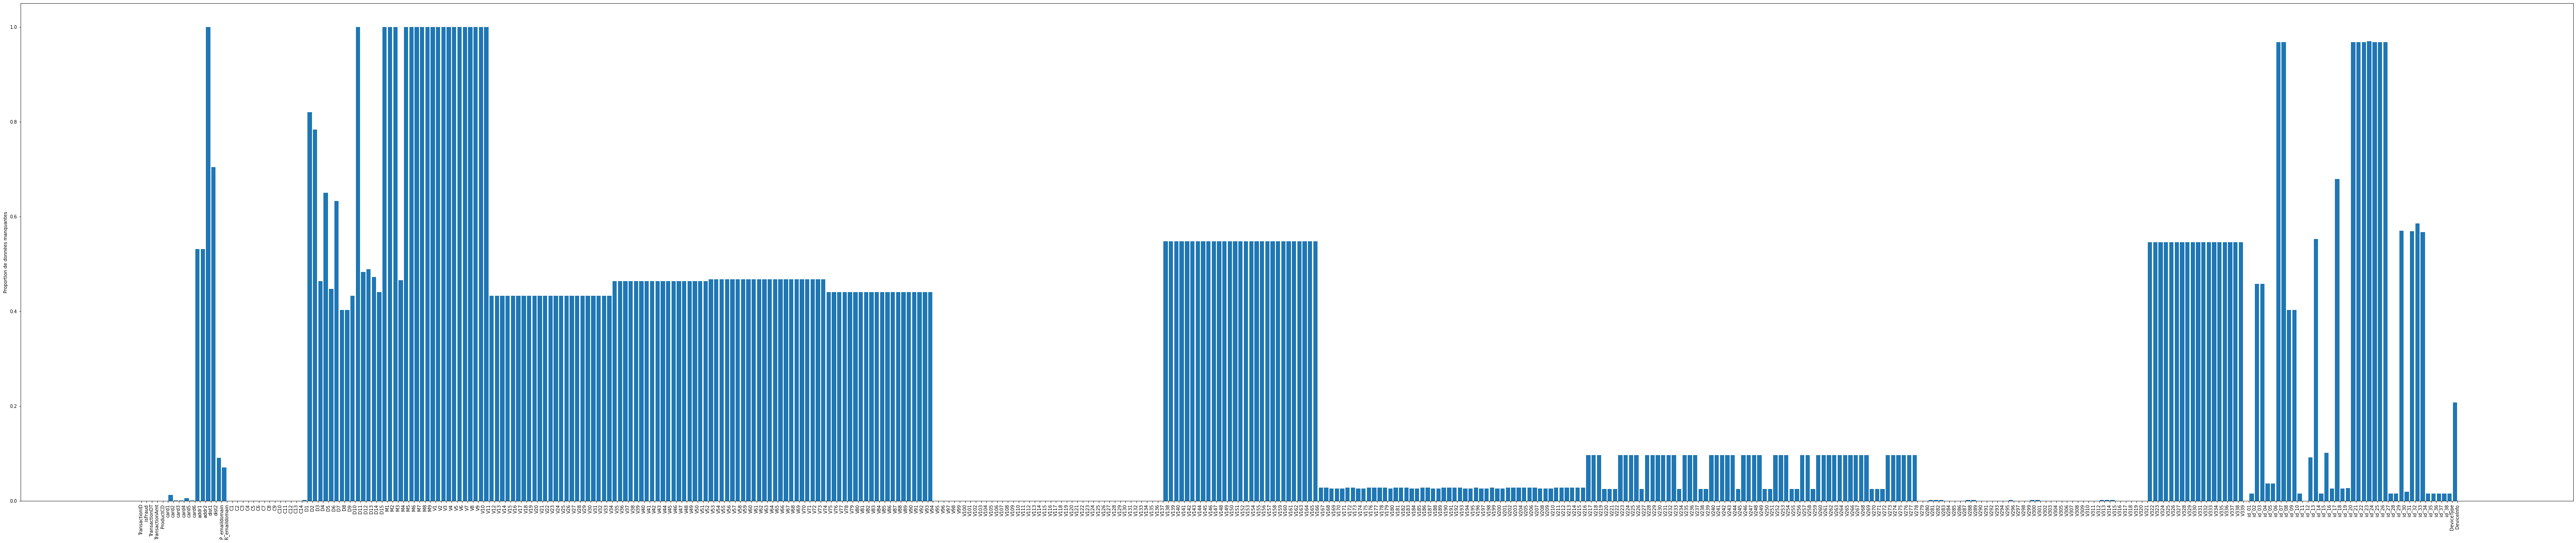

In [ ]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue précédemment. 

Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

In [ ]:
del tab, missing_data, total_data, class0, class1, class0_downsample, train

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

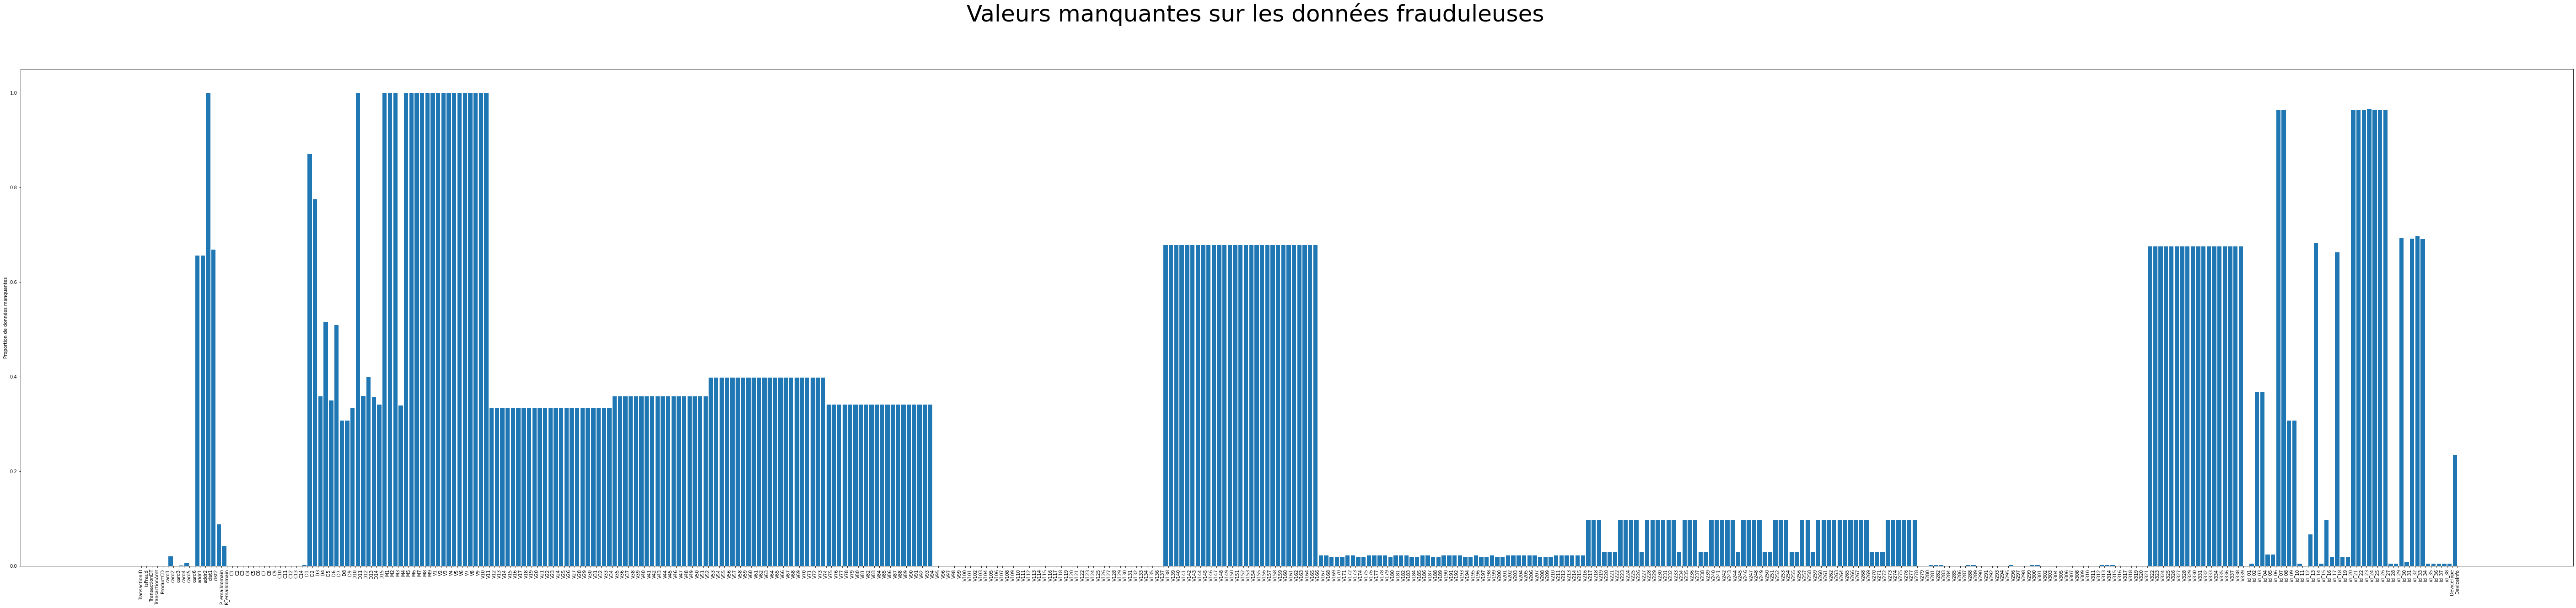

In [ ]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

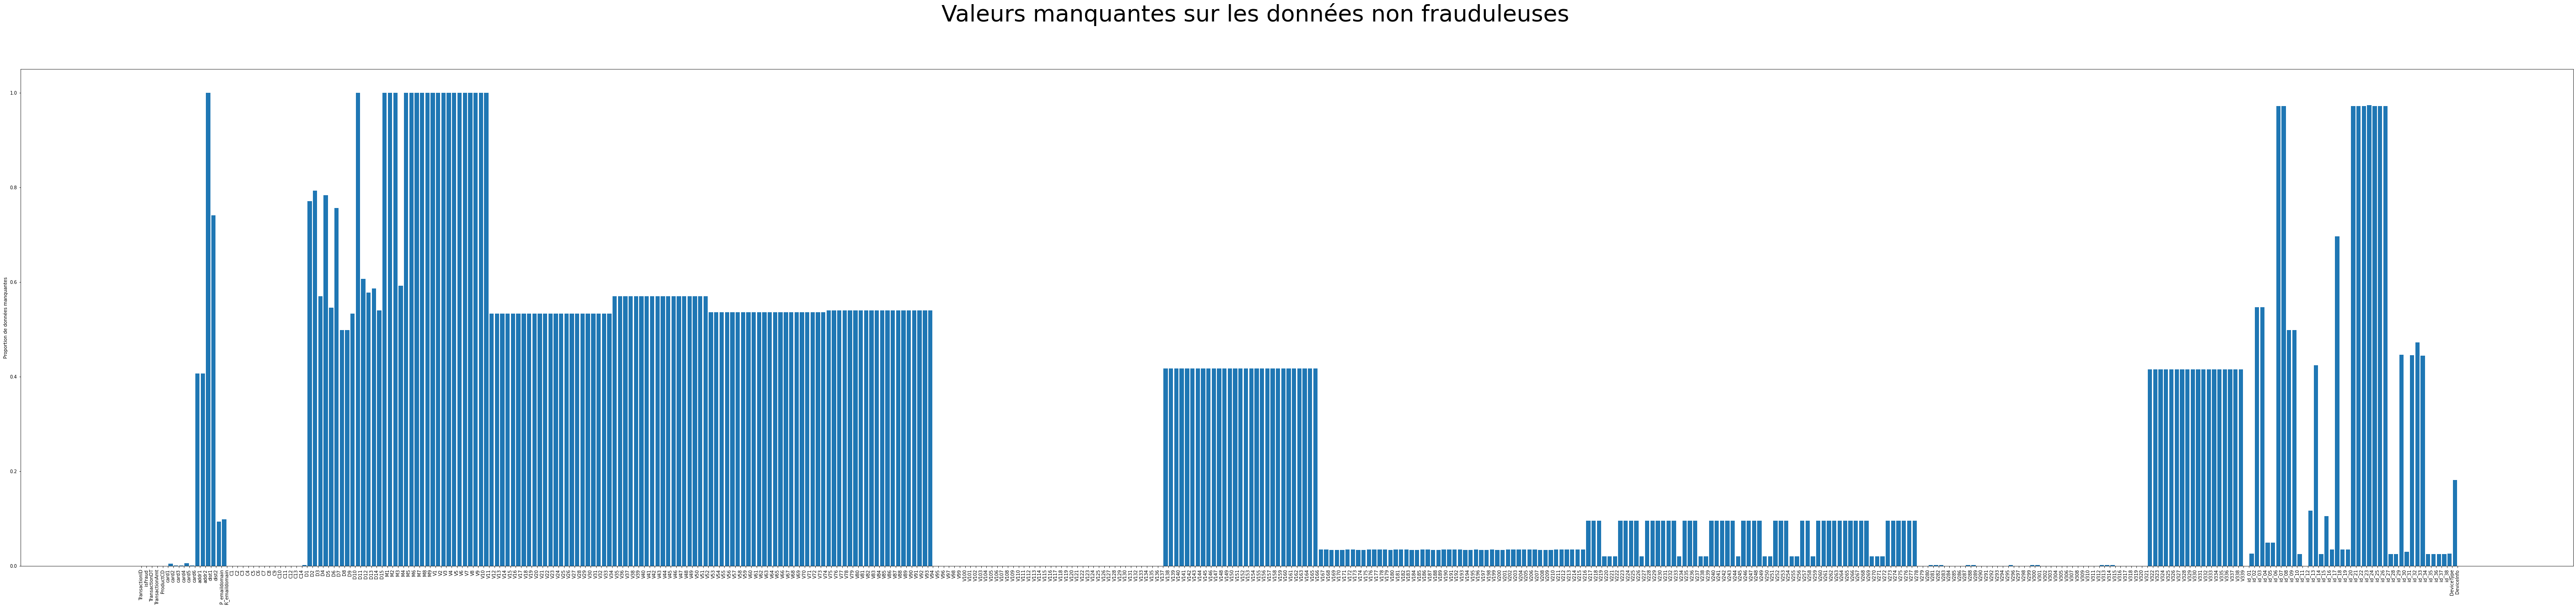

In [ ]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On en déduit que la variable d'intérêt n'a pas un effet générateur de données manquantes. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil de données manquantes.

**Courbe de sensibilité**

In [ ]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


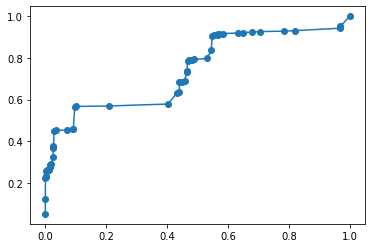

In [ ]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

La courbe de sensibilié nous révèlent qu'il existe un saut important entre 40% et 60% de données manquantes. Sans perte de généralités, on peut essayer de se restreindre à des variables possédant moins de 20% de données manquantes afin de ne pas dénaturer la base à l'issue de l'imputation des données manquantes.

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

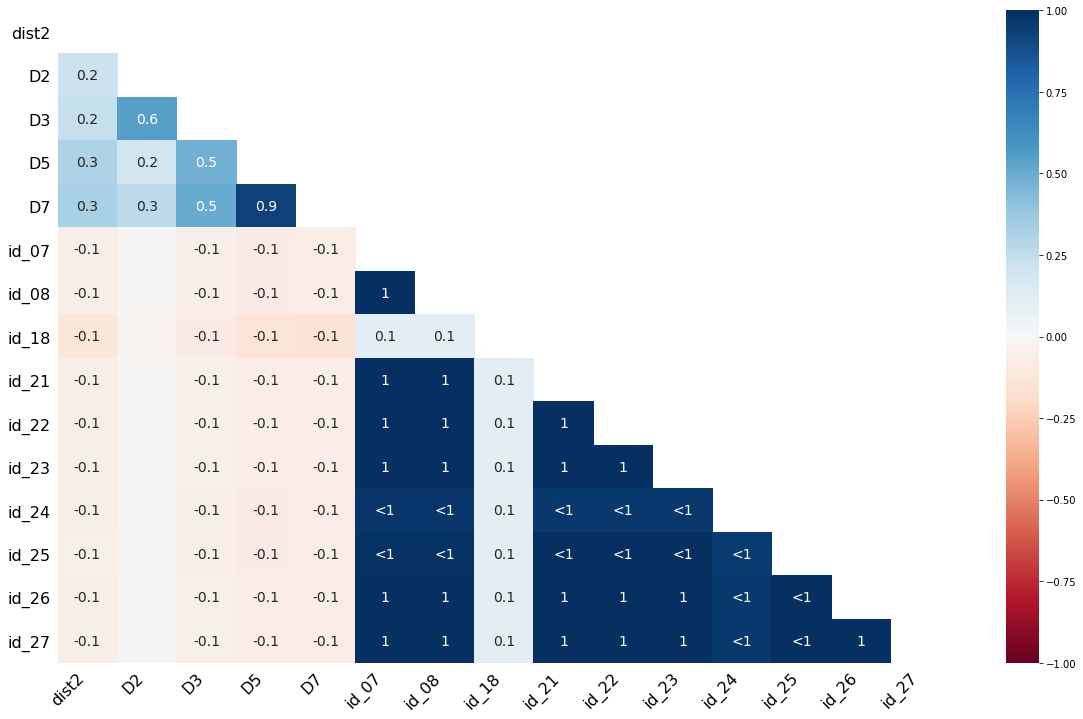

In [ ]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. 

**Traitement des valeurs manquantes**

In [ ]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(5828, 246)

In [ ]:
del train_calibrate, column_miss, my_series, sensibility_graph, null_counts, train_data_miss_60

**Imputation des variables quantitatives par la méthode du KNN**

Une méthode usuelle d'imputation des données manquantes pour les variables catégorielles est la méthode du KNN. Elle consiste à remplacer les données manquantes par un résumé statistique des valeurs des individus considérés voisins vis-à-vis de certaines caractéristiques.

In [ ]:
tps1 = time.clock()
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))
tps2 = time.clock()
time_treatment_var_manquant_KNN = tps2-tps1
print('Temps execution du traitement des valeurs manquantes:', tps2-tps1)

Temps execution du traitement des valeurs manquantes: 12.264368000000047


In [ ]:
train_imputed

array([[3.119625e+06, 0.000000e+00, 2.652959e+06, ..., 2.250000e+02,
        5.850000e+02, 5.070000e+02],
       [3.099647e+06, 0.000000e+00, 2.199978e+06, ..., 1.660000e+02,
        5.290000e+02, 1.610000e+02],
       [3.359428e+06, 0.000000e+00, 9.257530e+06, ..., 2.250000e+02,
        2.660000e+02, 4.690000e+02],
       ...,
       [3.290449e+06, 1.000000e+00, 7.507690e+06, ..., 1.660000e+02,
        5.290000e+02, 2.220000e+02],
       [3.028324e+06, 1.000000e+00, 1.014827e+06, ..., 2.250000e+02,
        2.660000e+02, 5.070000e+02],
       [3.206064e+06, 1.000000e+00, 5.137187e+06, ..., 1.660000e+02,
        1.930000e+02, 2.660000e+02]])

**Imputation des variables catégorielles par le mode**

In [ ]:
cat_cols = train_work.select_dtypes(exclude='object').columns
train_work.loc[:,cat_cols] = train_work[cat_cols].fillna(train_work[cat_cols].mode().iloc[0])

**Reconstitution de la base de travail**

In [ ]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,3119625.0,0.0,2652959.0,25.419,1333.0,170.0,150.0,195.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-5.0,272815.0,0.0,-41.0,100.0,25.0,225.0,585.0,507.0,C,visa,credit,earthlink.net,earthlink.net,NotFound,New,NotFound,New,NotFound,chrome 63.0 for android,F,F,T,T,mobile
1,3099647.0,0.0,2199978.0,100.000,1555.0,582.0,150.0,224.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-5.0,55645.0,0.0,0.0,100.0,52.0,166.0,529.0,161.0,H,mastercard,debit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 63.0,T,F,T,T,desktop
2,3359428.0,0.0,9257530.0,14.644,12839.0,321.0,150.0,226.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,64.067497,64.067497,49.423599,49.423599,49.423599,49.423599,49.423599,49.423599,49.423599,14.6439,14.6439,14.6439,0.0,0.0,0.0,-10.0,356663.0,0.0,0.0,100.0,33.0,225.0,266.0,469.0,C,visa,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,mobile safari generic,F,F,T,F,mobile
3,3472255.0,0.0,12624403.0,150.000,7987.0,532.0,150.0,224.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-5.0,167587.0,0.0,0.0,100.0,64.0,166.0,529.0,178.0,R,mastercard,debit,yahoo.com,yahoo.com,NotFound,New,NotFound,New,NotFound,mobile safari generic,T,F,F,T,mobile
4,3078201.0,0.0,1894813.0,100.000,6019.0,583.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,100.0,100.0,100.0,-5.0,304130.0,0.0,0.0,100.0,52.0,166.0,669.0,484.0,R,visa,credit,gmail.com,gmail.com,Found,Found,Found,Found,Found,edge 16.0,T,F,T,T,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,3412778.0,1.0,10773972.0,8.730,11408.0,555.0,185.0,226.0,5.0,6.0,0.0,4.0,0.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-15.0,194486.0,0.0,0.0,100.0,64.0,225.0,290.0,401.0,C,visa,credit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome generic,F,F,T,F,desktop
5824,3293615.0,1.0,7609035.0,10.030,4461.0,375.0,185.0,224.0,5.0,5.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,2.0,3.0,3.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-60.0,661528.0,0.0,0.0,100.0,33.0,225.0,266.0,507.0,C,mastercard,debit,live.com,live.com,NotFound,Found,Found,Found,Found

In [ ]:
del train_work, cat_cols

### **Analyse et traitement des valeurs aberrantes**

Pour détecter les valeurs aberrantes, nous abvons utilisé la méthode du boxplot qui considère comme aberrant toute valeur se trouvant au delà de certaines valeurs seuils. Après détection, vient la phase de traitement. Pour cette partie, il existe deux méthodes courantes qui sont la **winsorisation** et l'**imputation**. La winsorisation qui consiste à ramener toutes les valeurs abérrantes au seuil statistiquement raisonnable n'a pas été adoptée en raison du fait qu'elle peut s'avérer inappropriée en cas d'erreur de saisie. Quand à la méthode par imputation elle consiste à remplacer les valeurs dites aberrantes par des données manquantes et à procéder à leur imputation par une méthode usuelle comme le KNN.

**Détection des valeurs aberrantes**

In [ ]:
#detection des valeurs aberrantes
def replace_VA(df_in, col_name):
       q1 = df_in[col_name].quantile(0.25)
       q3 = df_in[col_name].quantile(0.75)
       iqr = q3-q1 #Interquartile range
       fence_low  = q1-1.5*iqr
       fence_high = q3+1.5*iqr
       for i in range(len(df_in[col_name])):
          if df_in[col_name][i]!='NaN':
            if df_in[col_name][i]< fence_low or df_in[col_name][i]>fence_high:
              df_in[col_name][i]=np.NaN

In [ ]:
train_imputed['TransactionID']=train_imputed['TransactionID'].astype(int)
df=train_imputed.select_dtypes(exclude='object')
df_object=train_imputed.select_dtypes(exclude='float64')


In [ ]:
#traitement des valeurs manquantes 
tps1 = time.clock()
for i in range(3,len(df.columns)):
  varc=df.columns[i]
  replace_VA(df, varc)
tps2 = time.clock()
print('Temps de remplacement des valeurs aberrantes en NaN', tps2-tps1)

Temps de remplacement des valeurs aberrantes en NaN 68.30121600000001


In [ ]:
#On utilise le KNN précedent pour traiter les NaN créés
tps1 = time.clock()
df_ok = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(df)
df_ok = pd.DataFrame(df_ok)
df_ok.columns = df.columns
tps2 = time.clock()
time_treatment_var_aberrant = tps2-tps1
print('Temps execution des valeurs aberrantes:', tps2-tps1)

Temps execution des valeurs aberrantes: 44.133550999999954


In [ ]:
#Base de données après traitement des valeurs aberrantes 
train_imputed=pd.merge(df_ok,df_object,on="TransactionID",how="right")

In [ ]:
train_imputed 

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,3119625.0,0.0,2652959.0,25.4190,1333.0,170.0,150.0,195.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,272815.0,0.0,-5.24,100.0,46.0,225.0,585.0,507.0,C,visa,credit,earthlink.net,earthlink.net,NotFound,New,NotFound,New,NotFound,chrome 63.0 for android,F,F,T,T,mobile
1,3099647.0,0.0,2199978.0,100.0000,1555.0,582.0,150.0,224.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,55645.0,0.0,0.00,100.0,52.0,166.0,529.0,161.0,H,mastercard,debit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 63.0,T,F,T,T,desktop
2,3359428.0,0.0,9257530.0,14.6440,12839.0,321.0,150.0,226.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,64.067497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,356663.0,0.0,0.00,100.0,52.0,225.0,266.0,469.0,C,visa,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,mobile safari generic,F,F,T,F,mobile
3,3472255.0,0.0,12624403.0,150.0000,7987.0,532.0,150.0,224.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,167587.0,0.0,0.00,100.0,52.0,166.0,529.0,178.0,R,mastercard,debit,yahoo.com,yahoo.com,NotFound,New,NotFound,New,NotFound,mobile safari generic,T,F,F,T,mobile
4,3078201.0,0.0,1894813.0,100.0000,6019.0,583.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,304130.0,0.0,0.00,100.0,52.0,166.0,387.2,484.0,R,visa,credit,gmail.com,gmail.com,Found,Found,Found,Found,Found,edge 16.0,T,F,T,T,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,3412778.0,1.0,10773972.0,8.7300,11408.0,555.0,185.0,226.0,5.0,6.0,0.0,1.0,0.0,1.4,0.4,4.0,0.0,3.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.0,194486.0,0.0,0.00,100.0,52.0,225.0,290.0,401.0,C,visa,credit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome generic,F,F,T,F,desktop
5824,3293615.0,1.0,7609035.0,10.0300,4461.0,375.0,185.0,224.0,5.0,5.0,0.0,3.0,0.0,3.0,0.8,3.0,0.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,164277.0,0.0,0.00,100.0,52.0,225.0,266.0,507.0,C,mastercard,debit,live.com,live.com,NotFound,Found,Found,Found,Found,chrome generic,F,F,T,F,desktop
5825,3290449.0,1.0,7507690.0,19.0926,1704.0,567.0,150.0,203.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,67632.0,0.0,0.00,100.0,52.0,166.0,529.0,222.0,R,masterca

In [ ]:
del df, df_object, varc, df_ok

### **Traitement des variables qualitatives**

De manière générale, le traitement des variables qualitatives à consister à regrouper de manières automatiques les modalités qui véhiculent des informations similaires.

In [ ]:
# Nombre de modalités par variable
train_imputed.select_dtypes('object').nunique()

ProductCD          4
card4              4
card6              2
P_emaildomain     46
R_emaildomain     47
id_12              2
id_15              3
id_16              2
id_28              2
id_29              2
id_31            101
id_35              2
id_36              2
id_37              2
id_38              2
DeviceType         2
dtype: int64

On remarque que certaines variables possèdent un nombre important de modalités, on va donc s'atteler à créer des méthodes automatiques de traitement textuel. Il s'agit de *P_emaildomain, R_emaildomain et de id_31*.

In [ ]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))

gmail.com           2656
hotmail.com         1041
NaN                  530
anonymous.com        503
yahoo.com            383
outlook.com          157
aol.com              130
comcast.net           58
icloud.com            39
yahoo.com.mx          33
outlook.es            24
live.com              22
live.com.mx           21
msn.com               21
sbcglobal.net         20
me.com                20
verizon.net           18
bellsouth.net         14
att.net               14
ymail.com             11
mail.com              10
protonmail.com        10
web.de                 9
cox.net                9
hotmail.es             8
prodigy.net.mx         8
optonline.net          7
hotmail.fr             6
charter.net            6
yahoo.de               5
mac.com                5
yahoo.fr               4
frontier.com           4
gmx.de                 3
suddenlink.net         2
juno.com               2
rocketmail.com         2
earthlink.net          2
sc.rr.com              2
hotmail.de             2


Un traitement efficace et simple serait de retirer les extensions afin de ne conserver que les noms de domaines.

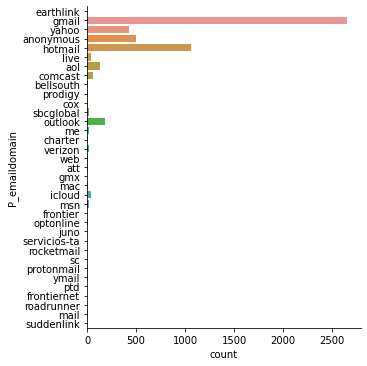

In [ ]:
train_imputed['P_emaildomain'] = train_imputed['P_emaildomain'].str.split('.').str.get(0)
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

On décide aussi finalement de regrouper les modalités non significatives dans une modalité autre.

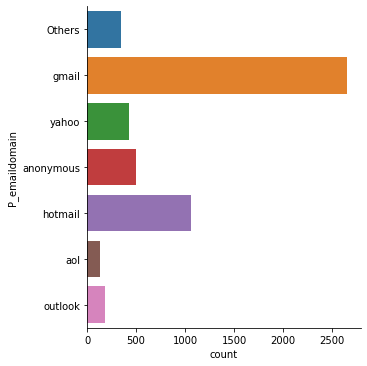

In [ ]:
#On regroupe les modalités peu significatives dans autres
prop = train_imputed['P_emaildomain'].value_counts()/len(train_imputed)
train_imputed['P_emaildomain'] = np.where(train_imputed['P_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['P_emaildomain'])
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

On procède à un taitement similaire pour la variable *R_emaildomain* étant donné qu'elle se présente sous le même format.

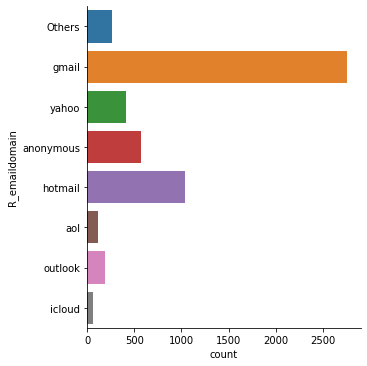

In [ ]:
train_imputed['R_emaildomain'] = train_imputed['R_emaildomain'].str.split('.').str.get(0)
prop = train_imputed['R_emaildomain'].value_counts()/len(train_imputed)
train_imputed['R_emaildomain'] = np.where(train_imputed['R_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['R_emaildomain'])
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

In [ ]:
#Traitement textuel de la variable sur les navigateurs
print(train_imputed['id_31'].value_counts(dropna=False))

chrome 63.0                       816
mobile safari generic             513
mobile safari 11.0                495
chrome 65.0                       326
chrome generic                    300
chrome 64.0                       292
chrome 63.0 for android           268
ie 11.0 for desktop               240
safari generic                    227
chrome 62.0                       226
chrome 66.0                       208
chrome 65.0 for android           203
chrome 64.0 for android           191
edge 16.0                         124
chrome 66.0 for android           124
NaN                               116
firefox 57.0                      109
mobile safari 10.0                106
chrome 62.0 for android            86
chrome generic for android         49
edge 15.0                          49
firefox 58.0                       43
firefox                            43
firefox 59.0                       41
chrome 49.0                        34
chrome 61.0 for android            30
samsung brow

En ce qui concerne le navigateur utiliser, on peut noter que l'existence de différentes versions entrainent l'existence de plusieurs modalités qui sont en réalité relatives à la même entité. On décide donc d'écrire un algorithme pour l'identification de similarité syntaxique et la labélisation.

Dans un premier temps, il s'agit d'identifier les similarités. Pour ce faire, on utilise la théorie des *ngrams* du *NLP (Natural Langage Processing)*. En particulier, vu le nombre peu important de mots par observations, on fera un **1gram**. On calcul alors un coefficient de ressemblance entre les modalités et on réalise un heatmap pour la visualisation. Enfin, on passe par une recherche sémantique des termes récurrents pour donner des labels aux modalités qui sont jugées similaires.

In [ ]:

def ngram(sentence, len_gram):
  """
    Fonction for splitting sentences into d-grammes
  """
  sentence = sentence.strip()
  sentence_split = re.split(r'[/\-,\s]\s*', sentence)
  words = [] 
  if len_gram >= len(sentence.split()) :
    sent_len = 1
  else :
    sent_len = len(sentence.split()) - len_gram +1
  for i in range(sent_len):
      words.append(sentence.split()[i:i+len_gram]) 
  return words

def diff_ngram(sent_a, sent_b, len_gram):
  """
    Fonction to evaluate correspondance between sentences
  """
  a = ngram(sent_a, len_gram)
  b = ngram(sent_b, len_gram) 
  cnt = 0 
  for i in a:
      for j in b:
          if i == j:
              cnt += 1
  return cnt/len(a)

def calculate_similarities(sentences):
  matrix_comparison = np.zeros((len(sentences), len(sentences)))
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      matrix_comparison[i][j] = diff_ngram(sentences[i], sentences[j], 1)
  mat = pd.DataFrame(matrix_comparison).set_index(sentences)
  mat.columns = sentences
  return mat

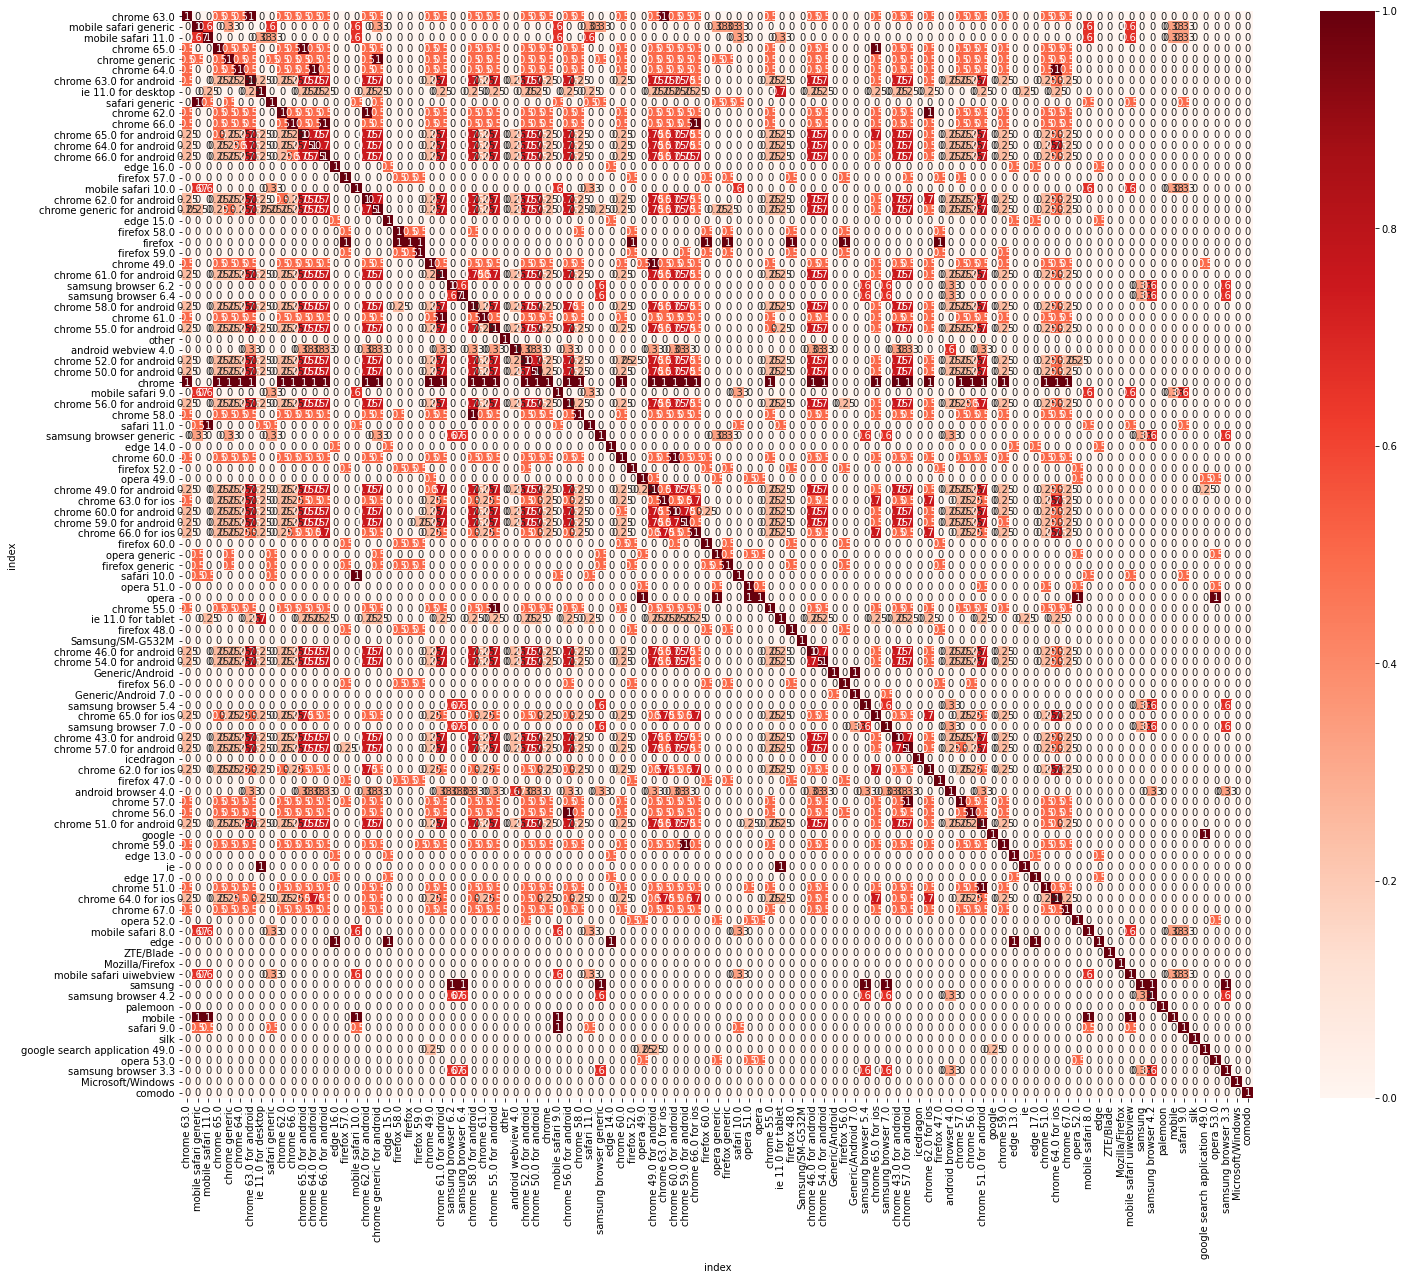

In [ ]:
values = train_imputed['id_31'].value_counts().reset_index()['index']
mat = calculate_similarities(values)
plt.figure(figsize=(24,20))
sns.heatmap(mat, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Select the max per column
### First we replace on the diagonal the 1 value
i = 0
for var in mat.columns:
  mat[var][i] = 0
  i += 1
mod_list = list()
for var in mat.columns:
  tmp = mat[var][mat[var]>=0.75].reset_index()['index']
  tmp[len(tmp)] = var
  mod_list.append(np.array(tmp))

In [ ]:
def common_words(text1, text2) :
  text1_words = text1.strip().split()
  text2_words = text2.strip().split()
  common = set(text1_words).intersection( set(text2_words) )
  text = ' '.join(common).strip()
  return text

In [ ]:
prev_value = []
new_value = []

for elt in mod_list :
  if len(elt) > 1 :
    common_text = elt[0]
    for i in range(1,len(elt)) :
      common_text = common_words(common_text, elt[i])
    if common_text.strip() == "" :
      common_text = elt[-1]
    for val in elt :
      prev_value.append(val)
      new_value.append(common_text)

In [ ]:
corr_mat = pd.DataFrame(prev_value,new_value).reset_index()
corr_mat.columns = ["New", "Prev"]
corr_mat = corr_mat.drop_duplicates('Prev')

In [ ]:
train_imputed_b = pd.merge(train_imputed,corr_mat,how = 'left', left_on='id_31', right_on='Prev')
train_imputed_b['id_31'] = np.where(train_imputed_b['New'].isnull(),train_imputed_b['id_31'],train_imputed_b['New'])
train_imputed_b = train_imputed_b.drop(["New","Prev"], axis= 1)

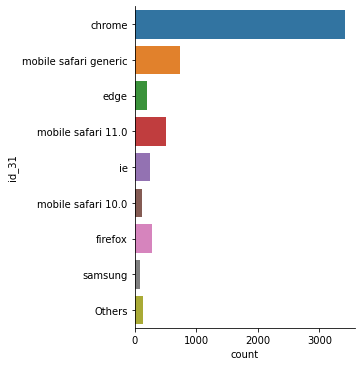

In [ ]:
prop = train_imputed_b['id_31'].value_counts()/len(train_imputed_b)
train_imputed_b['id_31'] = np.where(train_imputed_b['id_31'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed_b['id_31'])
sns.catplot(y='id_31',kind='count',data=train_imputed_b)

In [ ]:
#On voit le nombre de modalités par variable
train_imputed_b.select_dtypes('object').nunique()

ProductCD        4
card4            4
card6            2
P_emaildomain    7
R_emaildomain    8
id_12            2
id_15            3
id_16            2
id_28            2
id_29            2
id_31            9
id_35            2
id_36            2
id_37            2
id_38            2
DeviceType       2
dtype: int64

On se retrouve finalement avec un nombre de modalités acceptables pour les variables qualitatives.

Ensuite, afin que les algorithmes puissent traiter convenablement les variables qualitatives, on créé des variables binaires pur chacune des modalités.

In [ ]:
#On met les variables categorielles dans un type exploitable
quali_col = train_imputed_b.select_dtypes('object').columns
for var in quali_col :
  train_imputed_b[var] = train_imputed_b[var].astype('category')

train_quant = train_imputed_b.drop(quali_col,axis=1)
col_to_keep = train_imputed_b.columns
train_imputed_b = pd.merge(train_quant,pd.get_dummies(train_imputed_b[quali_col]),right_index=True,left_index=True)

In [ ]:
del train_imputed, prop, values, mat, mod_list, tmp, prev_value, new_value, common_text, corr_mat, train_quant, quali_col

## Modelisation

In [ ]:
Y=train_imputed_b['isFraud'].astype('int')
X=train_imputed_b.drop('isFraud',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

In [ ]:
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)

Dans un premier temps, on compare les temps d'exécution entre calcul distribué ou non afin de retenir la méthode de calcul utilisée. Le choix sera axé dans une minimisation des temps de traitement au niveau des CPU afin de réduire les consommations d'énergie et donc d'adopter une démarche plus verte.

In [ ]:
## Execution sur pandas
model = LogisticRegression()
%time model.fit(X_train_st, Y_train)

CPU times: user 337 ms, sys: 121 ms, total: 458 ms
Wall time: 247 ms


LogisticRegression()

In [ ]:
## Execution avec dask
with joblib.parallel_backend('dask'):
  model = LogisticRegression()
  %time model.fit(X_train_st, Y_train)

CPU times: user 136 ms, sys: 93 ms, total: 229 ms
Wall time: 1.52 s


Comme on peut le voir les temps de traitements au niveau du CPU sont bien plus faible avec le traitement distribué. On adopte alors cette approche dans la suite.

### **Construction des modèles**

### Régression logistique

Bien qu'elle soit appelée régression, la régression logistique est en fait une technique de classification supervisée largement utilisée. La régression logistique et ses extensions, comme la régression logistique multinomiale, nous permettent de prédire la probabilité qu'une observation soit d'une certaine classe en utilisant une approche simple et bien comprise.

La Logistic Regression a un hyperparameter $C$ :  regularization parameter

\begin{equation}
        \Large p_+ = P\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right)
\end{equation}
[Logistic Regression](https://mlcourse.ai/articles/topic4-part2-logit/)

[ regularization parameter](https://mlcourse.ai/articles/topic4-part3-regularization/)

In [ ]:
logit=LogisticRegression(C=1,random_state=42)
with joblib.parallel_backend('dask'):
  logit.fit(X_train_st, Y_train)
  cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8866038317828607

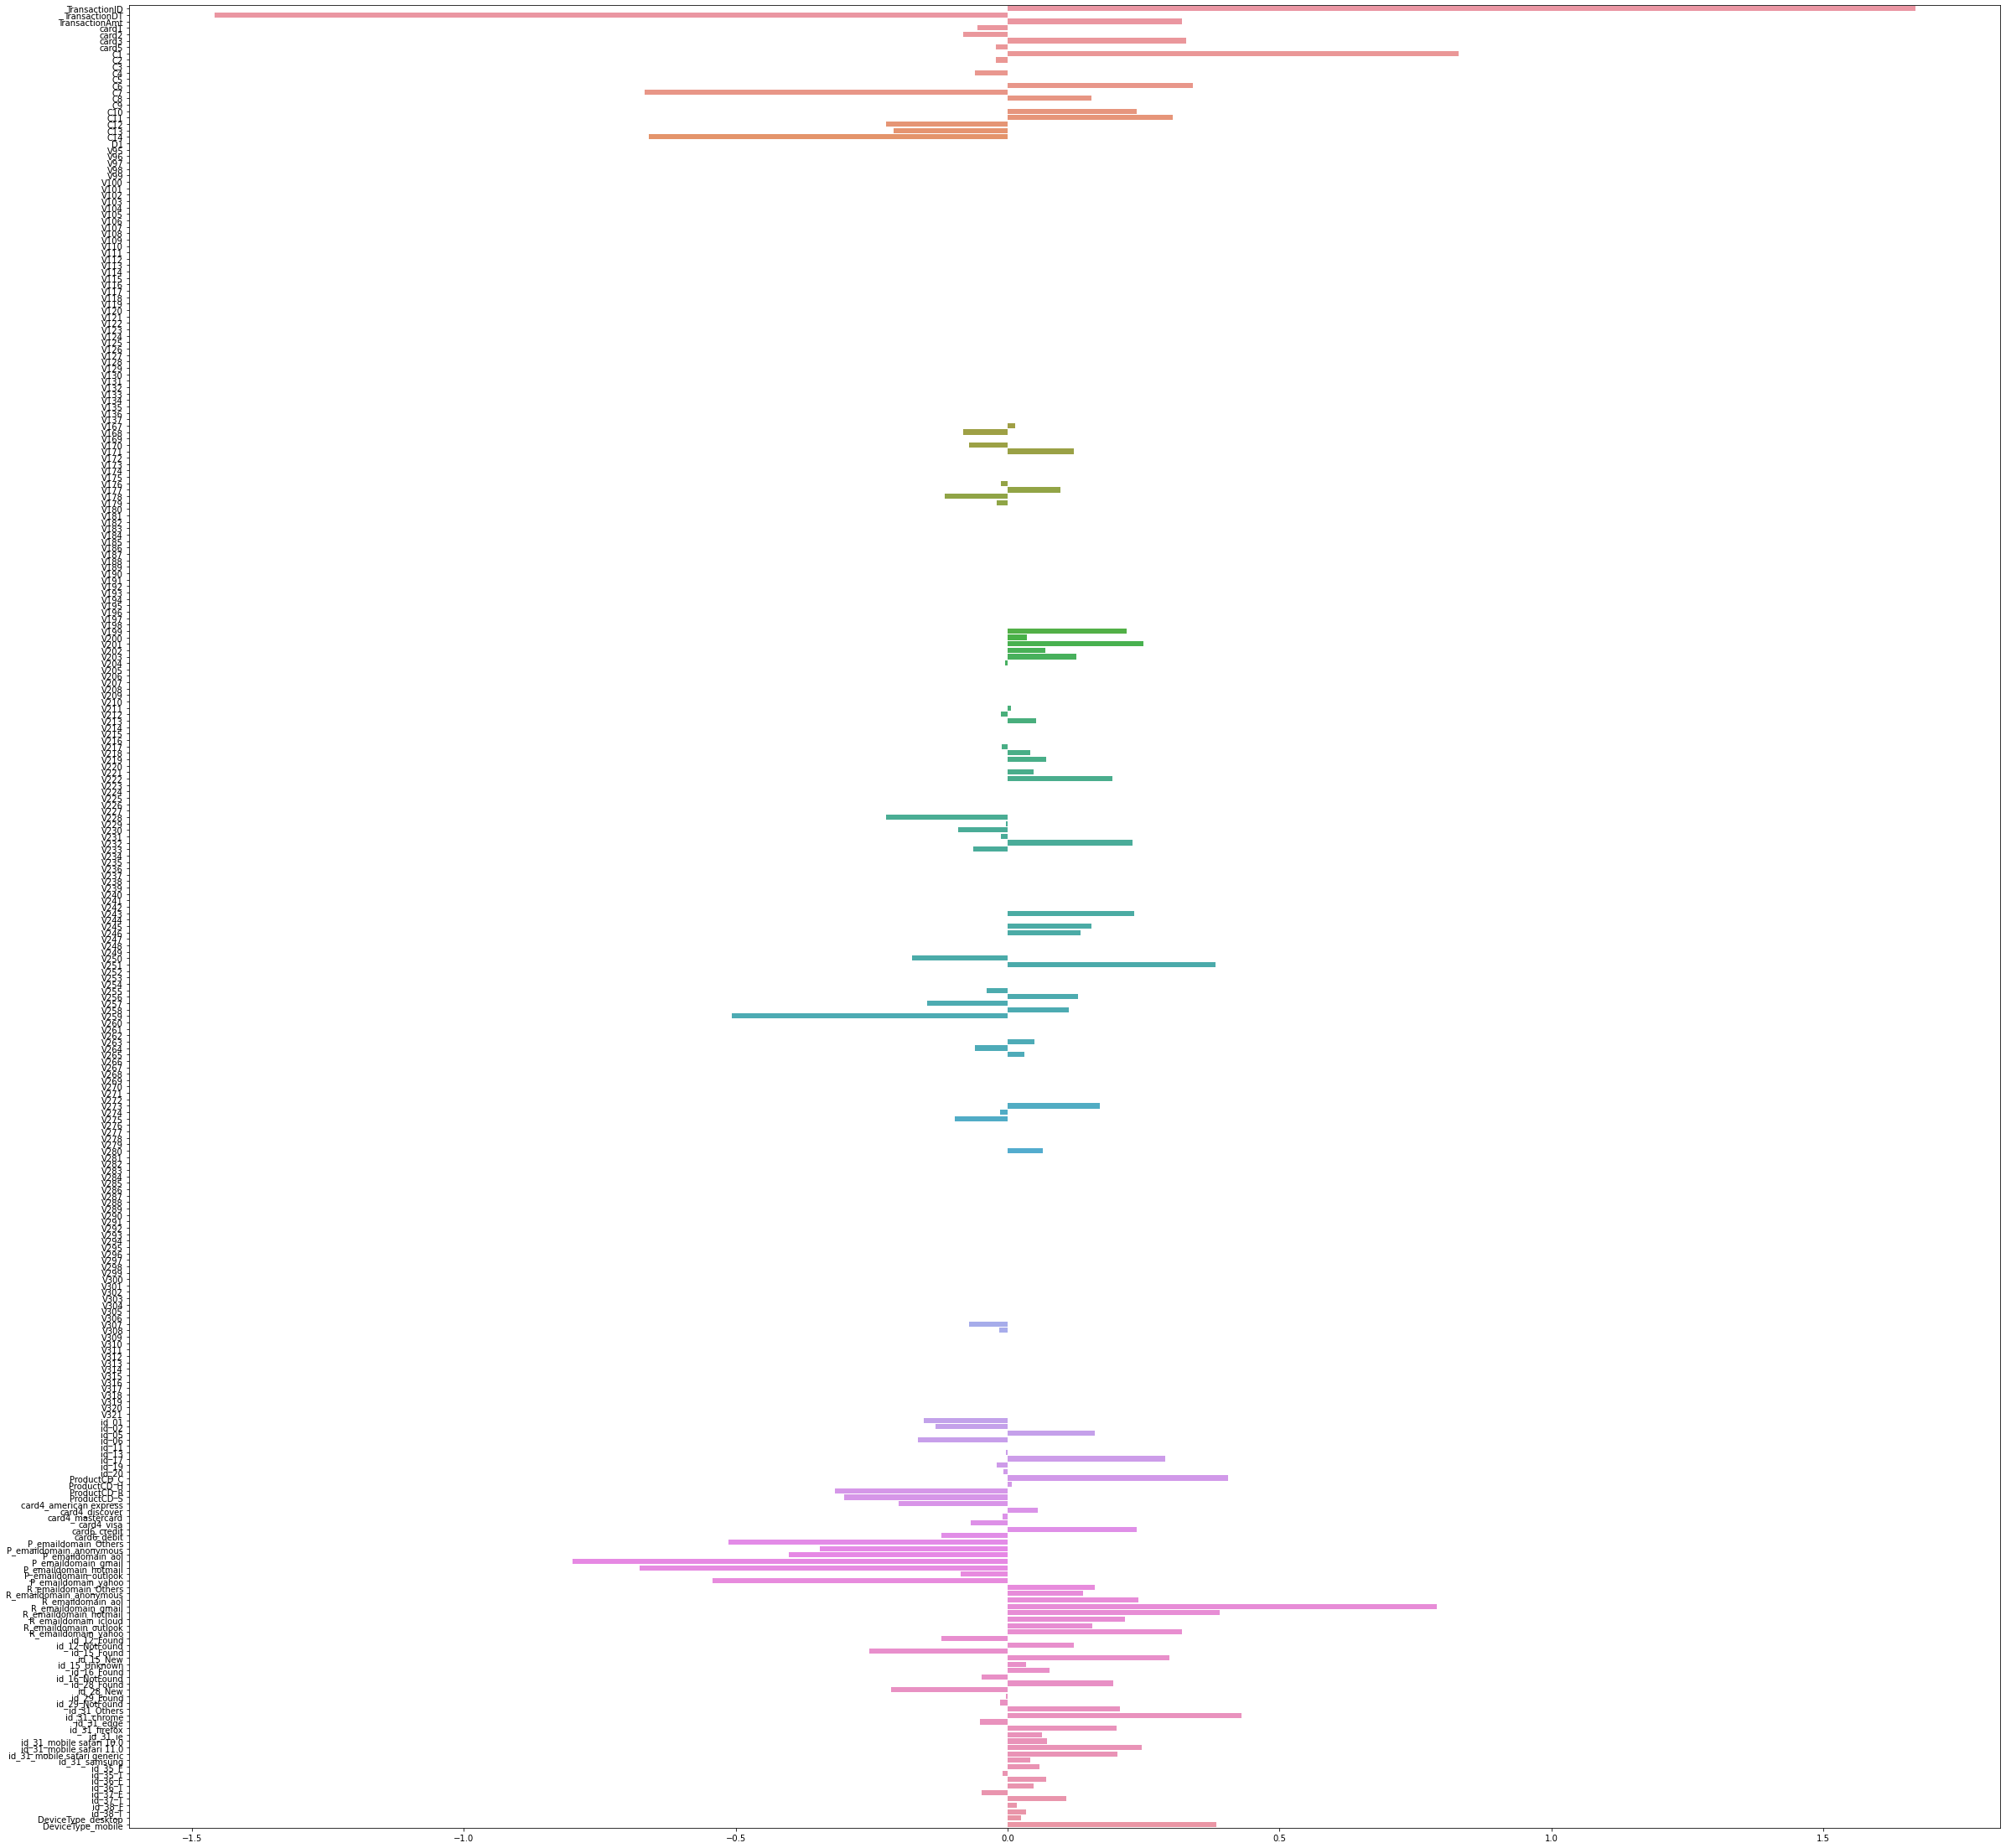

In [ ]:
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

Afin de compiler le mogèle logit avec les meilleurs paramètres, nous procédons à un tuning des paramètres pour sélection la meilleur valeur de **C**.

In [ ]:
#Courbe pour l'évolution du cv_score en fonction du paramètre C
vscores=np.zeros(50)
vtime=np.zeros(50)
for i in range(50):
  tps1 = time.clock()
  with joblib.parallel_backend('dask'):
    logit=LogisticRegression(C=i+1,random_state=42)
    cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
  tps2 = time.clock()
  vscores[i]=cv_scores.mean()
  vtime[i]=tps2-tps1

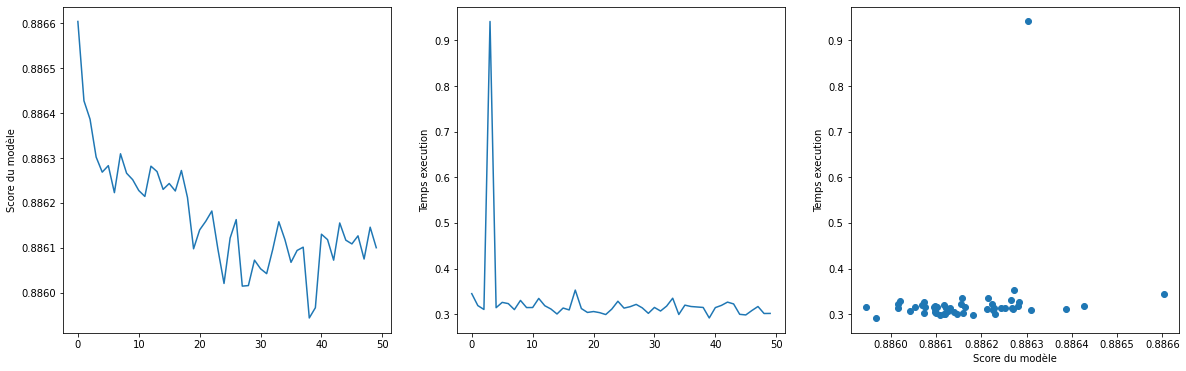

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.plot(vscores)
plt.ylabel('Score du modèle')

plt.subplot(132)
plt.plot(vtime)
plt.ylabel('Temps execution')

plt.subplot(133)
plt.scatter(vscores,vtime)
plt.ylabel('Temps execution')
plt.xlabel('Score du modèle')
plt.show()


In [ ]:
del model, importance, imp, vscores, vtime

**Sélection de variables par la méthode du Recursive Feature Elimination with Cross Validation (RFECV)**

In [ ]:
logit=LogisticRegression(C=9,random_state=42)
with joblib.parallel_backend('dask'):
  cv_selector = RFECV(logit,cv= 2, step=1,scoring="accuracy")
  cv_selector = cv_selector.fit(X_train_st, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans

In [ ]:
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
   rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)

Optimal number of features : 59
Best features : ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card3', 'C1', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 'V199', 'V201', 'V203', 'V222', 'V228', 'V243', 'V245', 'V250', 'V251', 'V259', 'V273', 'id_05', 'id_06', 'id_17', 'ProductCD_C', 'ProductCD_R', 'ProductCD_S', 'card4_american express', 'card4_mastercard', 'card4_visa', 'card6_credit', 'card6_debit', 'P_emaildomain_Others', 'P_emaildomain_anonymous', 'P_emaildomain_aol', 'P_emaildomain_gmail', 'P_emaildomain_hotmail', 'P_emaildomain_yahoo', 'R_emaildomain_aol', 'R_emaildomain_gmail', 'R_emaildomain_hotmail', 'R_emaildomain_icloud', 'R_emaildomain_yahoo', 'id_12_Found', 'id_15_Found', 'id_15_New', 'id_16_Found', 'id_16_NotFound', 'id_28_Found', 'id_28_New', 'id_29_NotFound', 'id_31_Others', 'id_31_chrome', 'id_31_firefox', 'DeviceType_desktop', 'DeviceType_mobile']


In [ ]:
pp=[]
for i in range(len(cv_selector.support_)):
  if cv_selector.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
with joblib.parallel_backend('dask'):
  logit.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

0.8925742670338994

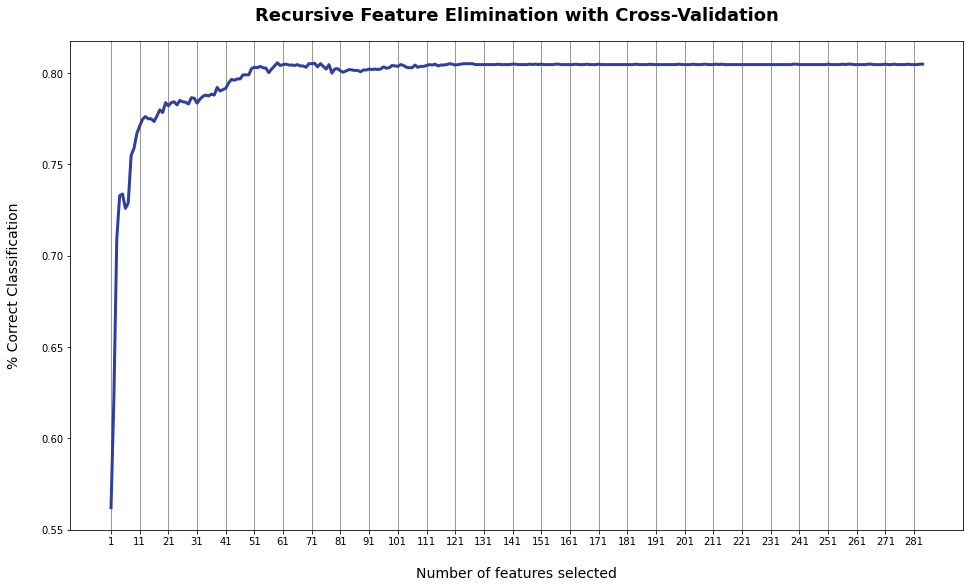

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(cv_selector.grid_scores_) + 1), cv_selector.grid_scores_, color='#303F9F', linewidth=3)
plt.xticks(range(1, len(cv_selector.grid_scores_) + 1,10))
plt.grid(True, axis = 'x', color = 'gray', zorder = 0)
plt.show()

**Model with best features from RFECV**

In [ ]:
logit_features = rfecv_features
X_train1= X_train.filter(logit_features,axis=1)
X_train_st1=scaler.fit_transform(X_train1)
with joblib.parallel_backend('dask'):
  logit.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8925742670338994

In [ ]:
## Confusion matrix 
with joblib.parallel_backend('dask'):
  Y_pred=logit.predict(X_train_st1)
  cnf_matrix = metrics.confusion_matrix(Y_train,Y_pred)
cnf_matrix

array([[1703,  324],
       [ 399, 1653]])

Text(0.5, 257.44, 'Predicted label')

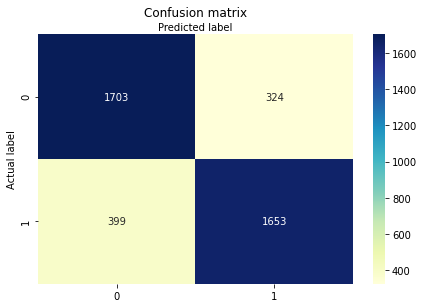

In [ ]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(Y_train,Y_pred))
print("Precision:",metrics.precision_score(Y_train,Y_pred))
print("Recall:",metrics.recall_score(Y_train,Y_pred))

Accuracy: 0.8227506741848493
Precision: 0.8361153262518968
Recall: 0.8055555555555556


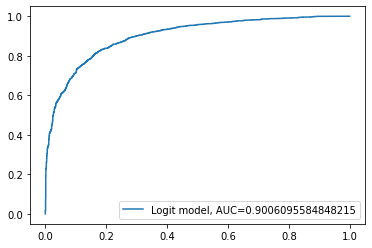

In [ ]:
# ROC Curve
with joblib.parallel_backend('dask'):
  Y_pred_proba = logit.predict_proba(X_train_st1)[::,1]
  fpr, tpr, _ = metrics.roc_curve(Y_train,  Y_pred_proba)
  auc = metrics.roc_auc_score(Y_train, Y_pred_proba)
plt.plot(fpr,tpr,label="Logit model, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
del cv_selector, rfecv_mask, rfecv_features

### Decision Tree Classifier

L'arbre de décision est un puissant classificateur qui utilise une structure arborescente pour modéliser les relations entre les caractéristiques et les résultats potentiels.
Cette forme de structure tient son nom en raison du fait qu’elle reflète comment un arbre littéral commence en un tronc large qui, s’il est suivi vers le haut, se divise en branches plus étroites. De la même manière, les arbres de décision utilisent une structure de décisions, qui canalisent les caractéristiques en une valeur de classe finale prédite.

In [ ]:
with joblib.parallel_backend('dask'):
  decision_tree_gini=DecisionTreeClassifier(criterion='gini',random_state=42)
  decision_tree_gini.fit(X_train, Y_train)
  cv_scores = cross_val_score(decision_tree_gini, X_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.7666377779655207

### Random Forest

Les forêts aléatoires sont une modification des arbres de décision de manière à
constituer une grande collection d’arbres décorrélés pour améliorer davantage les performances prédictives. Ils sont devenus un algorithme d’apprentissage « *prêt à l’emploi* » très populaire qui bénéficie de bonnes performances prédictives. Avec une Random Forest on construit une « **forêt d’arbres** » (donc, plusieurs arbres de décision), de manière aléatoire. C’est cela qui lui vaut d’appartenir aux « *ensemble method* », pour construite ce modele : une multitude de modèles « faibles » sont combinés pour créer un modèle robuste.
Une fois le modèle construit, les données sont lancées dans tous les arbres, qui
votent pour la classe d’appartenance en sortie.

**Sélection de variables**

In [ ]:
with joblib.parallel_backend('dask'):
  rf = RandomForestClassifier(random_state =42)
  rf.fit(X_train, Y_train)
  cv_selector = RFECV(rf,cv= 2, step=1,scoring="accuracy")
  cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
  rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)


Optimal number of features : 139
Best features : ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'C1', 'C2', 'C3', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V97', 'V98', 'V106', 'V112', 'V167', 'V168', 'V170', 'V171', 'V176', 'V177', 'V178', 'V179', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V211', 'V212', 'V213', 'V217', 'V218', 'V219', 'V221', 'V222', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V243', 'V245', 'V246', 'V250', 'V251', 'V255', 'V256', 'V257', 'V258', 'V259', 'V263', 'V264', 'V265', 'V273', 'V274', 'V275', 'V280', 'V284', 'V294', 'V301', 'V302', 'V307', 'V308', 'id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_17', 'id_19', 'id_20', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'card4_american express', 'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit', 'card6_debit', 'P_emaildomain_Others', 'P_emaildomain_anonymous', 'P_emaildomain_aol', 'P_emaildomain_gmail'

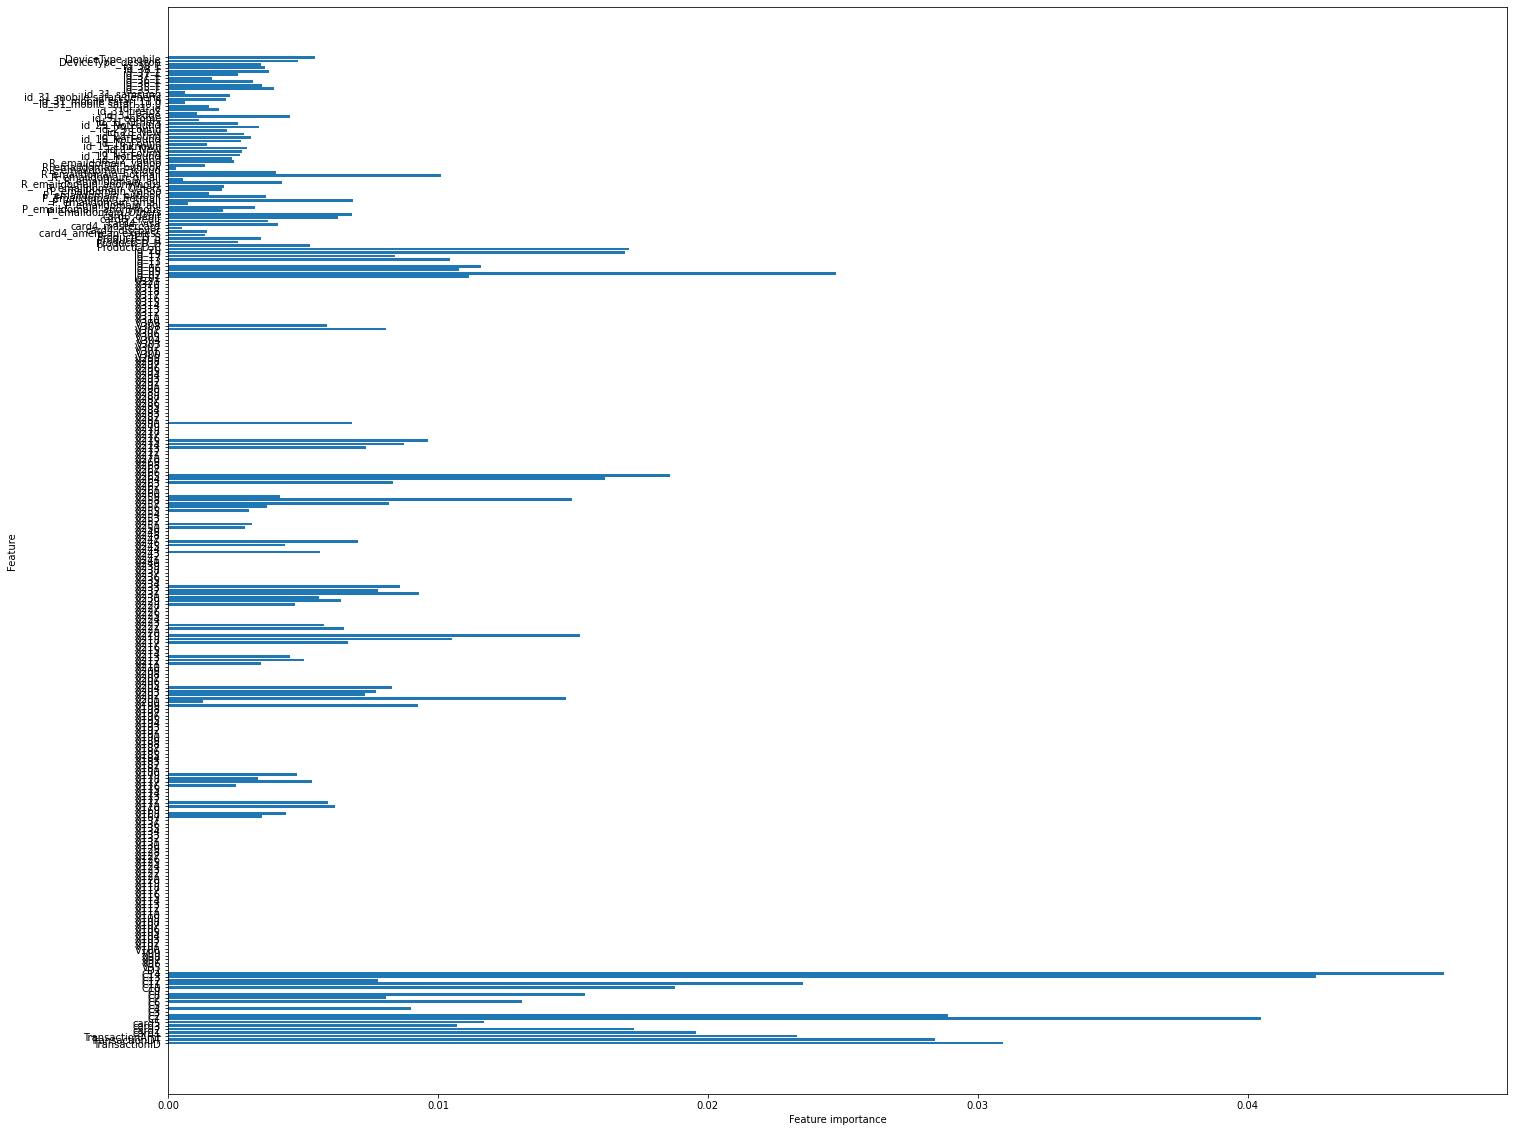

In [ ]:
n_features = X_train.shape[1]
plt.figure(figsize=(24,20))
plt.barh(range(n_features), rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

**Entrainement du modèle**

In [ ]:
rf_features = rfecv_features
X_train_rf=X_train.filter(rf_features,axis=1)
with joblib.parallel_backend('dask'):
  rf=RandomForestClassifier(random_state=42,n_jobs=-1,criterion="gini")
  rf.fit(X_train_rf, Y_train)
  cv_scores = cross_val_score(rf, X_train_rf, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.9163490619149037

In [ ]:
del cv_selector, rfecv_mask, rfecv_features, n_features, X_train_rf

### SVM

Pour comprendre les SVM, nous devons comprendre les hyperplans. Un hyperplan est un sous-espace à n - 1 dans un espace à n dimensions. Bien que cela semble com‐plex, c'est en fait assez simple. Par exemple, si nous voulions diviser un espace à deux dimensions, nous utiliserions un hyperplan à une dimension (c'est-à-dire une ligne). Si nous voulions
pour diviser un espace tridimensionnel, nous utiliserions un hyperplan bidimensionnel (c.-à-d.
un morceau de papier plat ou un drap de lit). Un hyperplan est simplement une généralisation de cette con‐
cept en n dimensions.
Les svm classifient les données en trouvant l'hyperplan qui maximise le
marge entre les classes dans les données d'entraînement. Dans un exemple bidimensionnel avec
deux classes, nous pouvons considérer un hyperplan comme la «bande» droite la plus large (c'est-à-dire la ligne avec
marges) qui sépare les deux classes.

Pour les classes qui sont lineairement inséparable, on utilise des Kernel. Ici on utilise le kernel $rbf$  qui a pour [formule](https://en.wikipedia.org/wiki/Radial_basis_function_kernel):

image.png

ou gamma ici est un hyperparameter

In [ ]:
# defining parameter range 
"""
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_st1, Y_train) 
print(grid.best_params_) 
"""

"\nparam_grid = {'C': [0.1, 1, 10, 100, 1000],  \n              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], \n              'kernel': ['rbf']}  \n  \ngrid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) \n  \n# fitting the model for grid search \ngrid.fit(X_train_st1, Y_train) \nprint(grid.best_params_) \n"

In [ ]:
with joblib.parallel_backend('dask'):
  Support_vector=SVC(C=1,gamma=0.001,kernel='rbf')
  Support_vector.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(Support_vector, X_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.5017073170731707

### Boosting (XGBoost)

Avec le boosting, une approche différente est adopté pour réaménager les modèles. Considérons un problème de classification dans lequel on commence avec un modèle de base et on l’applique aux données d’intérêt. Ensuite, le modèle est réaménagé, mais avec plus de poids (importance) accordé aux observations mal classées. Ce processus est répété jusqu’à ce qu’une règle d’arrêt soit atteinte.
L'algorithme XGBoost est un algorithme ensembliste qui agrège des arbres. À chaque itération, le nouvel arbre apprend de l'erreur commise par l'arbre précédent. Ainsi, même si chaque arbre a un pouvoir prédictif faible, la règle de décision construite en sommant le résultat de chaque arbre est elle très fiable.

**Sélection de variables**

In [ ]:
X_train_dummy = pd.get_dummies(X_train, prefix_sep='_', drop_first=True) 
with joblib.parallel_backend('dask'):
  xgbc=xgb.XGBClassifier(n_estimators=500,verbose=1,tree_method='hist')
  embeded_xgb_selector = SelectFromModel(xgbc)
  embeded_xgb_selector.fit(X_train_dummy, Y_train)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X_train_dummy.loc[:,embeded_xgb_support].columns.tolist()
final_tr= X_train_dummy[embeded_xgb_feature]

**Paramètre tuning**

In [ ]:
"""
param_test1 = {
 'max_depth':range(3,11,1),
 'min_child_weight':range(1,6,1)
}
with joblib.parallel_backend('dask'):
  gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
  param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
  gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
"""

"\nparam_test1 = {\n 'max_depth':range(3,11,1),\n 'min_child_weight':range(1,6,1)\n}\nwith joblib.parallel_backend('dask'):\n  gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,\n  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n  param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)\n  gsearch1.fit(X_train,Y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_\n"

**Entrainement du modèle**

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=123,
    min_child_weight = 5,
    tree_method='hist' )

with joblib.parallel_backend('dask'):
  xgb_best=model.fit(final_tr, Y_train)
  cv_scores = cross_val_score(xgb_best, final_tr, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.9325808473336892

In [ ]:
del embeded_xgb_selector, embeded_xgb_support

### **Validation des modèles**

**Régression logistique**

In [ ]:
X_test1= X_test.filter(logit_features,axis=1)
X_test_st1=scaler.fit_transform(X_test1)
with joblib.parallel_backend('dask'):
  start = time.time()
  Y_pred=logit.predict(X_test_st1)
  cv_scores = cross_val_score(logit, X_test_st1, Y_test, cv=5, scoring='roc_auc')
  end = time.time()
cv_scores.mean()
print("ROC AUC: ",cv_scores.mean())
print("Accuracy:",metrics.precision_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))
logit_infos = {'Model': ['Logit'], 'ROC_AUC' : [cv_scores.mean()], 'Accuracy' : [metrics.accuracy_score(Y_test,Y_pred)], 'Time' : [end-start]}
ML_infos = pd.DataFrame(logit_infos, columns= ["Model", "ROC_AUC", "Accuracy", "Time"])

ROC AUC:  0.8796969639020145
Accuracy: 0.8049353701527615
Precision: 0.8049353701527615
Recall: 0.7946635730858469


**Decision Tree**

In [ ]:
with joblib.parallel_backend('dask'):
  start = time.time()
  Y_pred=decision_tree_gini.predict(X_test)
  cv_scores = cross_val_score(decision_tree_gini, X_test, Y_test, cv=5, scoring='roc_auc')
  end = time.time()
cv_scores.mean()
print("ROC AUC: ",cv_scores.mean())
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))
dtree_infos = {'Model': ['Decision Tree'], 'ROC_AUC' : [cv_scores.mean()], 'Accuracy' : [metrics.accuracy_score(Y_test,Y_pred)], 'Time' : [end-start]}
dtree_infos = pd.DataFrame(dtree_infos, columns= ["Model", "ROC_AUC", "Accuracy", "Time"])
ML_infos = ML_infos.append(dtree_infos)

ROC AUC:  0.7324668065410602
Accuracy: 0.7672955974842768
Precision: 0.7660818713450293
Recall: 0.759860788863109


**Random Forest**

In [ ]:
X_test_rf=X_test.filter(rf_features,axis=1)
with joblib.parallel_backend('dask'):
  start = time.time()
  Y_pred=rf.predict(X_test_rf)
  cv_scores = cross_val_score(rf, X_test_rf, Y_test, cv=5, scoring='roc_auc')
  end = time.time()
cv_scores.mean()
print("ROC AUC: ",cv_scores.mean())
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))
rf_infos = {'Model': ['Random Forest'], 'ROC_AUC' : [cv_scores.mean()], 'Accuracy' : [metrics.accuracy_score(Y_test,Y_pred)], 'Time' : [end-start]}
rf_infos = pd.DataFrame(rf_infos, columns= ["Model", "ROC_AUC", "Accuracy", "Time"])
ML_infos = ML_infos.append(rf_infos)

ROC AUC:  0.8874117943910755
Accuracy: 0.8359062321326473
Precision: 0.8270762229806599
Recall: 0.8433874709976799


In [ ]:
del X_test_rf

**SVM**

In [ ]:
with joblib.parallel_backend('dask'):
  start = time.time()
  Y_pred=Support_vector.predict(X_test_st1)
  cv_scores = cross_val_score(Support_vector, X_test_st1, Y_test, cv=5, scoring='roc_auc')
  end = time.time()
cv_scores.mean()
print("ROC AUC: ",cv_scores.mean())
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))
svm_infos = {'Model': ['SVM'], 'ROC_AUC' : [cv_scores.mean()], 'Accuracy' : [metrics.accuracy_score(Y_test,Y_pred)], 'Time' : [end-start]}
svm_infos = pd.DataFrame(svm_infos, columns= ["Model", "ROC_AUC", "Accuracy", "Time"])
ML_infos = ML_infos.append(svm_infos)

ROC AUC:  0.8599584355517471
Accuracy: 0.7964551172098342
Precision: 0.8154613466334164
Recall: 0.7587006960556845


**XGBoost**

In [ ]:
X_test_dummy = pd.get_dummies(X_test, prefix_sep='_', drop_first=True) 
final_ts= X_test_dummy[embeded_xgb_feature]
with joblib.parallel_backend('dask'):
  start = time.time()
  Y_pred=xgb_best.predict(final_ts)
  cv_scores = cross_val_score(xgb_best, final_ts, Y_test, cv=5, scoring='roc_auc')
  end = time.time()
cv_scores.mean()
print("ROC AUC: ",cv_scores.mean())
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))
xgb_infos = {'Model': ['XGBoost'], 'ROC_AUC' : [cv_scores.mean()], 'Accuracy' : [metrics.accuracy_score(Y_test,Y_pred)], 'Time' : [end-start]}
xgb_infos = pd.DataFrame(xgb_infos, columns= ["Model", "ROC_AUC", "Accuracy", "Time"])
ML_infos = ML_infos.append(xgb_infos)

ROC AUC:  0.9029956016631155
Accuracy: 0.8524871355060034
Precision: 0.8503480278422274
Recall: 0.8503480278422274


In [ ]:
del final_ts

**Ensemblage de modèles**

In [ ]:
estimators = []
model1 = LogisticRegression(C=9,random_state=42)
estimators.append(('logistic', model1))
model2 = RandomForestClassifier(random_state=123,n_jobs=-1,criterion="gini")
estimators.append(('rf', model2))
model3 = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=123,
    min_child_weight = 5,
    tree_method='hist' )
estimators.append(('xgb', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators,voting='soft')
ensemble.fit(X_train,Y_train)
cv_scores.mean()
with joblib.parallel_backend('dask'):
  start = time.time()
  Y_pred=ensemble.predict(X_test)
  cv_scores = cross_val_score(ensemble, X_test, Y_test, cv=5, scoring='roc_auc')
  end = time.time()
print("ROC AUC: ",cv_scores.mean())
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))
ensemble_infos = {'Model': ['Ensemle Model'], 'ROC_AUC' : [cv_scores.mean()], 'Accuracy' : [metrics.accuracy_score(Y_test,Y_pred)], 'Time' : [end-start]}
ensemble_infos = pd.DataFrame(ensemble_infos, columns= ["Model", "ROC_AUC", "Accuracy", "Time"])
ML_infos = ML_infos.append(ensemble_infos)

ROC AUC:  0.8913366683060184
Accuracy: 0.8490566037735849
Precision: 0.8382352941176471
Recall: 0.8596287703016241


## Comparaison des modèles, discussion et conclusion

In [ ]:
ML_infos

,Model,ROC_AUC,Accuracy,Time
0,Logit,0.879697,0.803888,0.809352
0,Decision Tree,0.732467,0.767296,0.492088
0,Random Forest,0.887412,0.835906,4.203804
0,SVM,0.859958,0.796455,1.363886
0,XGBoost,0.902996,0.852487,12.613833
0,Ensemle Model,0.891337,0.849057,30.362546


Au terme, on note deux choix optimal possible.


*   *Le modèle le plus puissant* : **XGBoost**, il possède les meilleurs résultats en termes d'aire sous la courbe ROC et de taux de bon classement. Ainsi, pour arriver à des classifications plus que justes, ce modèle semble être le plus approprié. 
*   *Le modèle le modèle éco-responsable* : **Logit**, il n'est pas étonnant que le modèle logistique qui est l'un des plus simple obtient le deuxième temps de calcul le plus faible. Toutefois, son AUC et son taux de bon classement font de lui le modèle alliant à la fois, puissance et consommation faible en énergie.

Ainsi, malgré que le XGBoost possède les meilleurs résultats, le fait qu'il lui faille 12 fois plus de temps que le logit pour poduire des résultats font de lui une solution mitigée surtout aujourd'hui où la protection de l'environnement prend une place de plus en plus importante. Ainsi, pour une solution éco-responsable, nous préconisons l'utilisation du modèle logit. Toutefois, une confrontation supplémentaire de ces deux modèles pourra se faire sur données complètes et aussi sur serveurs avec de grandes capacités de calcul pour infirmer ou confirmer la conclusion de cette étude.



